1. [Общая статистика по каждому загрязнителю](#gen_stat)
    [Выводы](#gen_stat_conc)
2. [Оценка и удаление пропущенных, невалидных, неверифицированных значений. Проверки столбцов и их удаление](#mis_val)
    [Выводы](#mis_val_conc)
3. [Анализ и обработка выбросов](#outliers)
    [Выводы](#outliers_conc)
4. [Временные ряды концентраций загрязнителей](#ts_main)
    [Выводы](#ts_main_conc)
5. [Анализ корреляций между загрязнителями](#pol_cor)
    [Выводы](#pol_cor_conc)
6. [Анализ в разрезе Метаданных о станциях](#meta)
    [Статистика по концентрациям загрязнителей в разрезе типа местности - выводы](#meta_area_conc)
    [Статистика по концентрациям загрязнителей в разрезе типа станций - выводы](#meta_st_type_conc)

In [1]:
import warnings
import glob
import os
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Константы

In [2]:
USE_COLUMNS = ['Countrycode', 'AirQualityStation', 'UnitOfMeasurement', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'Validity', 'Verification']
CSV_PATH = '../datasources/aq/$pollutant_id$/'
CSV_FILTER = "*.csv"
POL_ID_PARAM = '$pollutant_id$'
METADATA_USE_COLUMNS = ['Countrycode', 'AirQualityStation', 'AirPollutantCode', 'Longitude', 'Latitude', 'Altitude', 'AirQualityStationType', 'AirQualityStationArea']
METADATA_CSV_PATH = '../datasources/aq/PanEuropean_metadata.csv'
POL_CODES = [7, 6001, 5, 10, 1, 8]
POL_NAMES = {7: "O3", 6001: "PM2.5", 5: "PM10", 10: "CO", 1: "SO2", 8: "NO2"}
POL_URL = "http://dd.eionet.europa.eu/vocabulary/aq/pollutant/"

In [3]:
country_code = 'NL'

##### Загрузка csv файлов в один dataframe для каждого загрязнителя. Вывод типов данных и первых строк для первого загрязнителя

In [4]:
df_list= list()

for pol_id in POL_CODES:
    df = pd.concat(map(lambda p: pd.read_csv(p, usecols=USE_COLUMNS), glob.glob(os.path.join(CSV_PATH.replace(POL_ID_PARAM, str(pol_id)), CSV_FILTER))))
    print(f'Pollutant: {pol_id}. Lines count: {df.shape[0]}')
    df_list.append(df)
display(df_list[0].dtypes)
df_list[0].head()

Pollutant: 7. Lines count: 4204583
Pollutant: 6001. Lines count: 4151572
Pollutant: 5. Lines count: 6350378
Pollutant: 10. Lines count: 889857
Pollutant: 1. Lines count: 1295931
Pollutant: 8. Lines count: 3824708


Countrycode           object
AirQualityStation     object
Concentration        float64
UnitOfMeasurement     object
DatetimeBegin         object
DatetimeEnd           object
Validity               int64
Verification           int64
dtype: object

,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
0,NL,STA-NL00230,44.62,µg/m3,2022-01-01 00:00:00 +01:00,2022-01-01 01:00:00 +01:00,1,3
1,NL,STA-NL00230,48.30,µg/m3,2022-01-01 01:00:00 +01:00,2022-01-01 02:00:00 +01:00,1,3
2,NL,STA-NL00230,39.56,µg/m3,2022-01-01 03:00:00 +01:00,2022-01-01 04:00:00 +01:00,1,3
3,NL,STA-NL00230,41.17,µg/m3,2022-01-01 04:00:00 +01:00,2022-01-01 05:00:00 +01:00,1,3
4,NL,STA-NL00230,42.64,µg/m3,2022-01-01 05:00:00 +01:00,2022-01-01 06:00:00 +01:00,1,3


<a id="gen_stat"></a>
***
#### Общая статистика по каждому загрязнителю
***

In [5]:
for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    display(df_list[i].describe(include='all'))

--------------------------------------------POLLUTANT O3--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,4204583,4204583,4.080000e+06,4204583,4204583,4204583,4.204583e+06,4.204583e+06
unique,1,51,NaN,1,85696,85696,NaN,NaN
top,NL,STA-NL00236,NaN,µg/m3,2013-12-13 08:00:00 +01:00,2013-12-13 09:00:00 +01:00,NaN,NaN
freq,4204583,94224,NaN,4204583,92,92,NaN,NaN
mean,NaN,NaN,4.543153e+01,NaN,NaN,NaN,9.621953e-01,1.286900e+00
std,NaN,NaN,2.737244e+01,NaN,NaN,NaN,3.722202e-01,7.010622e-01
min,NaN,NaN,-1.419000e+02,NaN,NaN,NaN,-1.000000e+00,1.000000e+00
25%,NaN,NaN,2.522000e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00
50%,NaN,NaN,4.582000e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00
75%,NaN,NaN,6.336000e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00


--------------------------------------------POLLUTANT PM2.5--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,4151572,4151572,3.960771e+06,4151572,4151572,4151572,4.151572e+06,4.151572e+06
unique,1,50,NaN,1,85733,85733,NaN,NaN
top,NL,STA-NL00937,NaN,µg/m3,2019-12-09 02:00:00 +01:00,2019-12-09 03:00:00 +01:00,NaN,NaN
freq,4151572,93891,NaN,4151572,69,69,NaN,NaN
mean,NaN,NaN,1.140736e+01,NaN,NaN,NaN,9.594893e-01,1.475133e+00
std,NaN,NaN,1.096638e+01,NaN,NaN,NaN,4.833225e-01,8.511842e-01
min,NaN,NaN,-1.580000e+01,NaN,NaN,NaN,-1.000000e+00,1.000000e+00
25%,NaN,NaN,4.886000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00
50%,NaN,NaN,8.500000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00
75%,NaN,NaN,1.473680e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00


--------------------------------------------POLLUTANT PM10--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,6350378,6350378,6.070628e+06,6350377,6350377,6350377,6.350377e+06,6.350377e+06
unique,1,81,NaN,1,85705,85705,NaN,NaN
top,NL,STA-NL00446,NaN,µg/m3,2013-03-11 01:00:00 +01:00,2013-03-11 02:00:00 +01:00,NaN,NaN
freq,6350378,94216,NaN,6350377,150,150,NaN,NaN
mean,NaN,NaN,1.947896e+01,NaN,NaN,NaN,9.411586e-01,1.273919e+00
std,NaN,NaN,1.502127e+01,NaN,NaN,NaN,4.494557e-01,6.876087e-01
min,NaN,NaN,-3.141000e+01,NaN,NaN,NaN,-1.000000e+00,1.000000e+00
25%,NaN,NaN,1.080000e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00
50%,NaN,NaN,1.715200e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00
75%,NaN,NaN,2.491000e+01,NaN,NaN,NaN,1.000000e+00,1.000000e+00


--------------------------------------------POLLUTANT CO--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,889857,889857,825599.000000,889857,889857,889857,889857.000000,889857.000000
unique,1,16,NaN,1,82763,82763,NaN,NaN
top,NL,STA-NL00551,NaN,mg/m3,2013-02-21 10:00:00 +01:00,2013-02-21 11:00:00 +01:00,NaN,NaN
freq,889857,82690,NaN,889857,23,23,NaN,NaN
mean,NaN,NaN,0.312691,NaN,NaN,NaN,0.860333,1.167993
std,NaN,NaN,0.176082,NaN,NaN,NaN,0.523541,0.554766
min,NaN,NaN,-0.093000,NaN,NaN,NaN,-1.000000,1.000000
25%,NaN,NaN,0.208000,NaN,NaN,NaN,1.000000,1.000000
50%,NaN,NaN,0.275000,NaN,NaN,NaN,1.000000,1.000000
75%,NaN,NaN,0.368000,NaN,NaN,NaN,1.000000,1.000000


--------------------------------------------POLLUTANT SO2--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,1295931,1295931,1.219188e+06,1295931,1295931,1295931,1.295931e+06,1.295931e+06
unique,1,16,NaN,1,85668,85668,NaN,NaN
top,NL,STA-NL00722,NaN,µg/m3,2013-03-17 09:00:00 +01:00,2013-03-17 10:00:00 +01:00,NaN,NaN
freq,1295931,94156,NaN,1295931,30,30,NaN,NaN
mean,NaN,NaN,2.644498e+00,NaN,NaN,NaN,1.032109e+00,1.214349e+00
std,NaN,NaN,5.660271e+00,NaN,NaN,NaN,6.216018e-01,6.186707e-01
min,NaN,NaN,-9.200000e+00,NaN,NaN,NaN,-1.000000e+00,1.000000e+00
25%,NaN,NaN,2.700000e-01,NaN,NaN,NaN,1.000000e+00,1.000000e+00
50%,NaN,NaN,1.100000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00
75%,NaN,NaN,3.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00


--------------------------------------------POLLUTANT NO2--------------------------------------------


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,3824708,3824708,3.704214e+06,3824707,3824707,3824707,3.824707e+06,3824707.0
unique,1,80,NaN,1,43824,43824,NaN,NaN
top,NL,STA-NL00643,NaN,µg/m3,2013-12-29 23:00:00 +01:00,2013-12-30 00:00:00 +01:00,NaN,NaN
freq,3824708,52584,NaN,3824707,145,145,NaN,NaN
mean,NaN,NaN,2.558325e+01,NaN,NaN,NaN,9.384818e-01,1.0
std,NaN,NaN,1.910708e+01,NaN,NaN,NaN,3.517392e-01,0.0
min,NaN,NaN,-4.890000e+00,NaN,NaN,NaN,-1.000000e+00,1.0
25%,NaN,NaN,1.100000e+01,NaN,NaN,NaN,1.000000e+00,1.0
50%,NaN,NaN,2.065000e+01,NaN,NaN,NaN,1.000000e+00,1.0
75%,NaN,NaN,3.570000e+01,NaN,NaN,NaN,1.000000e+00,1.0


<a id="gen_stat_conc"></a>
**Выводы:**
1. В столбце Concentration встречаются пропущенные значения, их необходимо исключить.
2. Есть невалидированные данные (Valifity <= 0 или неопределено), их необходимо исключить.
3. Есть неверифицированные данные (Verification != 1), их необходимо исключить.
4. Минимальные значения Concentration меньше нуля, что не имеет физического смысла, их необходимо исключить.
5. Максимальные значения Concentration на один-два порядка превышают средние и квинтили, что указывает на выбросы. Вероятно тоже исключить.
6. Встречается только одно значение для UnitOfMeasurement, значит не понадобится приводить единицы измерения, и столбец не нужен.

<a id="miss_val"><a>
***
#### Оценка и удаление пропущенных, невалидных, неверифицированных значений. Проверки столбцов и их удаление
***

In [6]:
def get_all_lines_count():
    return sum(x.shape[0] for x in df_list)

##### Оценка пропущенных значений

In [35]:
all_lines_count = get_all_lines_count()
invalid_lines_count = 0
print(f'Доли неверицированных значений (за исключением пропущенных) по загрязнителям:')
for i in range(len(POL_CODES)):
    dp = df_list[i][df_list[i]['Concentration'].isna()]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(dp.shape[0]/df_list[i].shape[0]*100, 2)}% значений')
    invalid_lines_count += dp.shape[0]

#null_lines_count = sum(x['Concentration'].isna().sum() for x in df_list)
print(f'Общая доля по всем загрязнителям: {round(invalid_lines_count/all_lines_count*100, 2)} %')

Доли неверицированных значений (за исключением пропущенных) по загрязнителям:
    Загрязнитель: O3 - 0.0% значений
    Загрязнитель: PM2.5 - 0.0% значений
    Загрязнитель: PM10 - 0.0% значений
    Загрязнитель: CO - 0.0% значений
    Загрязнитель: SO2 - 0.0% значений
    Загрязнитель: NO2 - 0.0% значений
Общая доля по всем загрязнителям: 0.0 %


##### Оценка неверифицированных значений (за исключением пропущенных)

In [33]:
invalid_lines_count = 0
print(f'Доли неверицированных значений (за исключением пропущенных) по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_cond = (~df_list[i]['Concentration'].isna()) & (df_list[i]['Verification'] != 1)
    dp = df_list[i][bad_cond]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(dp.shape[0]/df_list[i].shape[0]*100, 2)}% значений')
    invalid_lines_count += dp.shape[0]
print(f'Общая доля по всем загрязнителям: {round(invalid_lines_count/all_lines_count*100, 2)} %')

Доли неверицированных значений (за исключением пропущенных) по загрязнителям:


KeyError: 'Verification'

##### Оценка невалидных значений (за исключением пропущенных)

In [9]:
invalid_lines_count = 0
print(f'Доли невалидных значений (за исключением пропущенных) по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_cond = (~df_list[i]['Concentration'].isna()) & (df_list[i]['Validity'] <= 0)
    dp = df_list[i][bad_cond]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(dp.shape[0]/df_list[i].shape[0]*100, 2)}% значений')
    invalid_lines_count += df_list[i][bad_cond].shape[0]
print(f'Общая доля по всем загрязнителям: {round(invalid_lines_count/all_lines_count*100, 2)} %')

Доли невалидных значений (за исключением пропущенных) по загрязнителям:
    Загрязнитель: O3 - 0.0% значений
    Загрязнитель: PM2.5 - 0.0% значений
    Загрязнитель: PM10 - 0.0% значений
    Загрязнитель: CO - 0.0% значений
    Загрязнитель: SO2 - 0.0% значений
    Загрязнитель: NO2 - 0.0% значений
Общая доля по всем загрязнителям: 0.0 %


##### Оценка отрицательных и нулевых значений

In [34]:
invalid_lines_count = 0
print(f'Доли отрицательных и нулевых значений по загрязнителям:')
for i in range(len(POL_CODES)):
    bad_cond = df_list[i]['Concentration'] <= 0
    dp = df_list[i][bad_cond]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(dp.shape[0]/df_list[i].shape[0]*100, 2)}% значений')
    invalid_lines_count += df_list[i][bad_cond].shape[0]
print(f'Доля отрицательных и нулевых значений: {round(invalid_lines_count/all_lines_count*100, 2)} %')

Доли отрицательных и нулевых значений по загрязнителям:


TypeError: unhashable type: 'Series'

##### Удаление пропущенных, неверифицированных, невалидных, отрицательных и равных нулю значений

In [11]:
valid_lines_count = 0
print(f'Доли удаленных строк по загрязнителям:')
for i in range(len(POL_CODES)):
    good_cond = (~df_list[i]['Concentration'].isna()) & (df_list[i]['Verification'] == 1) & (df_list[i]['Validity'] > 0) & (df_list[i]['Concentration'] > 0)
    dp = df_list[i][good_cond]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round((df_list[i].shape[0] - dp.shape[0])/df_list[i].shape[0]*100, 2)}% значений')
    df_list[i]= dp
    valid_lines_count += df_list[i].shape[0]

print(f'Общая доля удаленных строк: {round((all_lines_count - valid_lines_count)/all_lines_count*100, 2)}%')

Доли удаленных строк по загрязнителям:
    Загрязнитель: O3 - 19.07% значений
    Загрязнитель: PM2.5 - 30.35% значений
    Загрязнитель: PM10 - 20.05% значений
    Загрязнитель: CO - 15.64% значений
    Загрязнитель: SO2 - 27.83% значений
    Загрязнитель: NO2 - 3.19% значений
Общая доля удаленных строк: 19.1%


##### Проверка временных интервалов измерения на предмет отличия от 1 часа. Оценка доли таких интервалов.
##### Удаление данных с интервалами, отличными от 1 часа. Удаление столбца DatetimeBegin

In [12]:
non_hour_lines_count = 0
all_lines_count = get_all_lines_count()
print(f'Доли интервалов, неравных 1 часу, по загрязнителям:')
for i in range(len(POL_CODES)):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df_list[i]['DatetimeEnd'] = pd.to_datetime(df_list[i]['DatetimeEnd'])
        df_list[i]['DatetimeBegin'] = pd.to_datetime(df_list[i]['DatetimeBegin'])
    df_hour_dif = df_list[i][((df_list[i]['DatetimeEnd'] - df_list[i]['DatetimeBegin']).dt.total_seconds() != 3600) & ~df_list[i]['Concentration'].isna()]
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(df_hour_dif.shape[0]/df_list[i].shape[0]*100, 2)}% значений')
    non_hour_lines_count += df_hour_dif.shape[0]

    if df_hour_dif is not None and df_hour_dif.shape[0] > 0:
        df_days_dif = df_hour_dif[((df_hour_dif['DatetimeEnd'] - df_hour_dif['DatetimeBegin']).dt.days != 1) & ~df_hour_dif['Concentration'].isna()]
        print(f'        Проверка: доля интервалов, неравных ни дню, ни часу: {round(df_days_dif.shape[0]/df_hour_dif.shape[0]*100, 2)} %')
        if df_days_dif is not None and df_days_dif.shape[0] > 0:
            print(df_days_dif.head())

    good_cond = (df_list[i]['DatetimeEnd'] - df_list[i]['DatetimeBegin']).dt.total_seconds() == 3600
    df_list[i]= df_list[i][good_cond]

print()
print(f'Удалено {round(non_hour_lines_count/all_lines_count*100, 2)} % строк')

Доли интервалов, неравных 1 часу, по загрязнителям:
    Загрязнитель: O3 - 0.0% значений
    Загрязнитель: PM2.5 - 0.29% значений
        Проверка: доля интервалов, неравных ни дню, ни часу: 0.0 %
    Загрязнитель: PM10 - 0.01% значений
        Проверка: доля интервалов, неравных ни дню, ни часу: 0.0 %
    Загрязнитель: CO - 0.0% значений
    Загрязнитель: SO2 - 0.0% значений


/tmp/ipykernel_46145/1887408346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i].loc[:, 'DatetimeEnd'] = pd.to_datetime(df_list[i].loc[:, 'DatetimeEnd'])
/tmp/ipykernel_46145/1887408346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i].loc[:, 'DatetimeBegin'] = pd.to_datetime(df_list[i].loc[:, 'DatetimeBegin'])


    Загрязнитель: NO2 - 0.0% значений

Удалено 0.05 % строк


##### Удаление столбцов Verification, Validity, UnitOfMeasurement, DatetimeBegin

In [13]:
for i in range(len(POL_CODES)):
    df_list[i] = df_list[i].drop(columns= ['Verification', 'Validity', 'UnitOfMeasurement', 'DatetimeBegin'])

In [14]:
df_list[0].head()

,Countrycode,AirQualityStation,Concentration,DatetimeEnd
0,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00
1,NL,STA-NL00446,61.52,2014-06-25 01:00:00+01:00
2,NL,STA-NL00446,22.22,2014-06-25 06:00:00+01:00
3,NL,STA-NL00446,59.66,2014-06-25 02:00:00+01:00
4,NL,STA-NL00446,62.27,2014-06-27 01:00:00+01:00


##### Переиндексация

In [15]:
for i in range(len(POL_CODES)):
    df_list[i].reset_index(drop=True, inplace=True)
df_list[0].head()

,Countrycode,AirQualityStation,Concentration,DatetimeEnd
0,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00
1,NL,STA-NL00446,61.52,2014-06-25 01:00:00+01:00
2,NL,STA-NL00446,22.22,2014-06-25 06:00:00+01:00
3,NL,STA-NL00446,59.66,2014-06-25 02:00:00+01:00
4,NL,STA-NL00446,62.27,2014-06-27 01:00:00+01:00


<a id="mis_val_conc"></a>
**Выводы:**
1. Данные с пропущенными, неверифицированными и невалидными концентрациям составляют значительную долю: около 20% для O3, PM2.5, PM10, CO; около 40% для SO2 и менее 3% для NO2.
    Но их в любом случае нельзя использовать, поэтому они были удалены.
2. Все единицы измерения в рамках загрязнителя одинаковы, столбец не несет полезной информации и был удален.
3. Временной интервал измерения за редким исключением составляет 1 час (менее 1% для PM2.5- это интервалы в 1 день). Чтобы не искажать результаты последующих расчетов, данные с отличными от 1 часа интервалами, были удалены.
4. Поскольку был зафиксирован интервал измерений длительностью в 1 час, один из столбцов с интервалом даты не несет полезной информации, поэтому столбец DatetimeBegin был удален.

<a id="outliers"></a>
***
#### Анализ и обработка выбросов
***

##### Анализ выбросов

--------------------------------------------POLLUTANT O3--------------------------------------------



count    3.402877e+06
mean     4.550108e+01
std      2.692134e+01
min      1.000000e-02
25%      2.560000e+01
50%      4.554000e+01
75%      6.288000e+01
max      2.789600e+02
Name: Concentration, dtype: float64

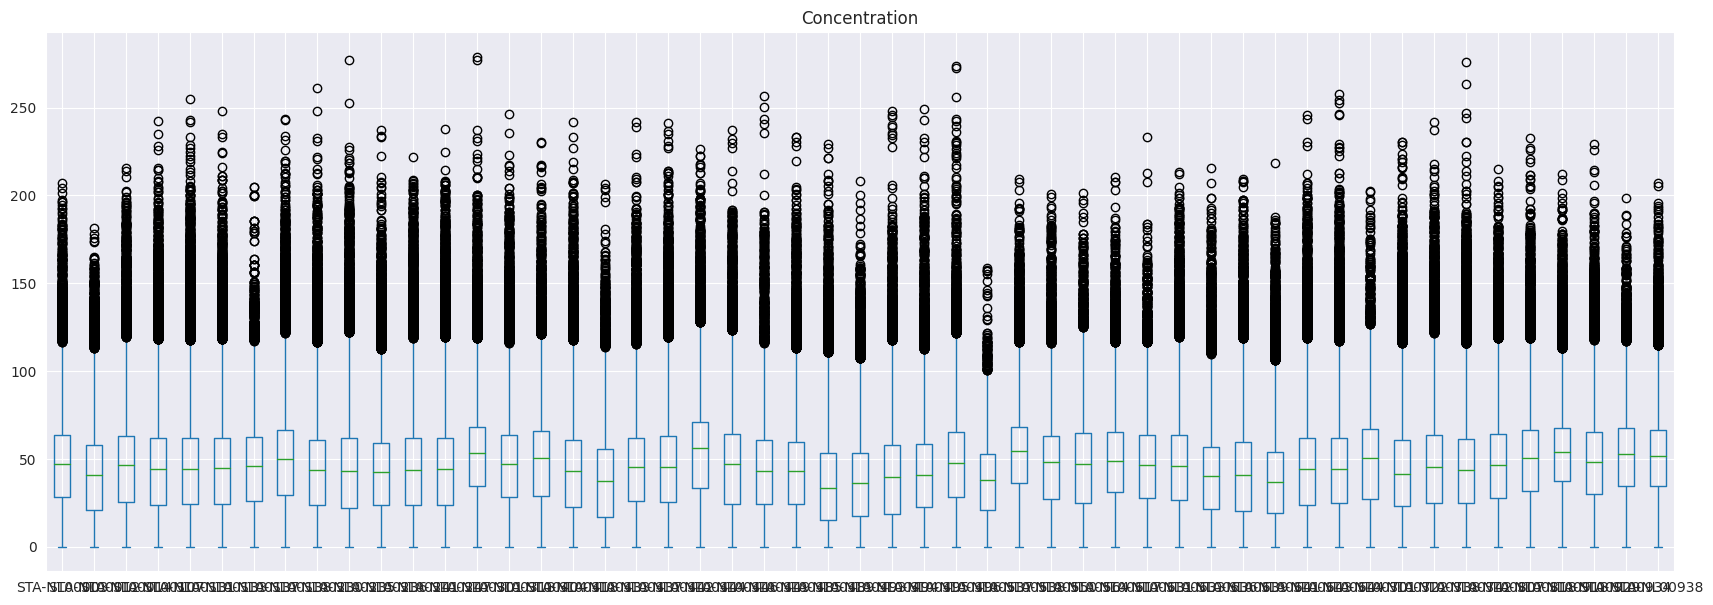

--------------------------------------------POLLUTANT PM2.5--------------------------------------------



count    2.883292e+06
mean     1.238830e+01
std      1.145941e+01
min      5.000000e-04
25%      5.400000e+00
50%      9.100000e+00
75%      1.599600e+01
max      1.558080e+03
Name: Concentration, dtype: float64

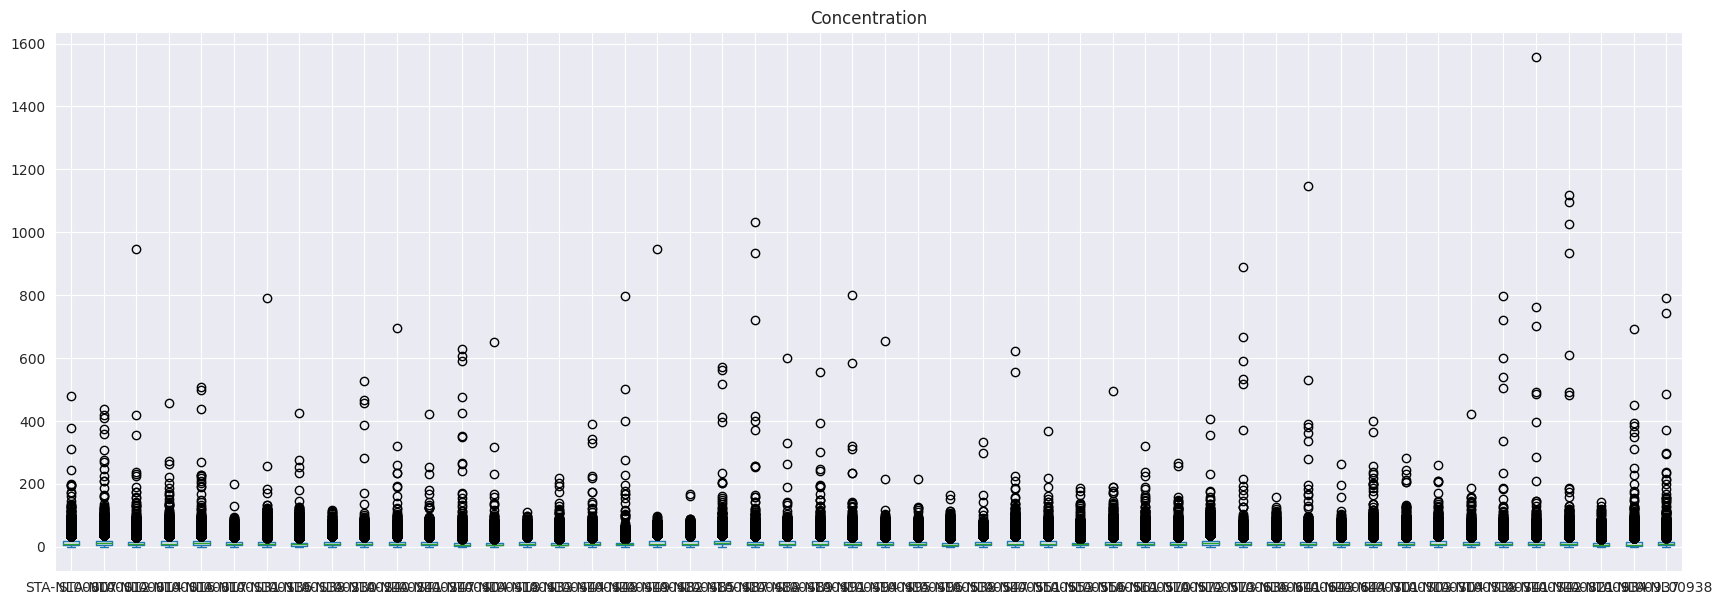

--------------------------------------------POLLUTANT PM10--------------------------------------------



count    5.076520e+06
mean     2.047814e+01
std      1.496572e+01
min      2.000000e-03
25%      1.100000e+01
50%      1.739000e+01
75%      2.619000e+01
max      1.893710e+03
Name: Concentration, dtype: float64

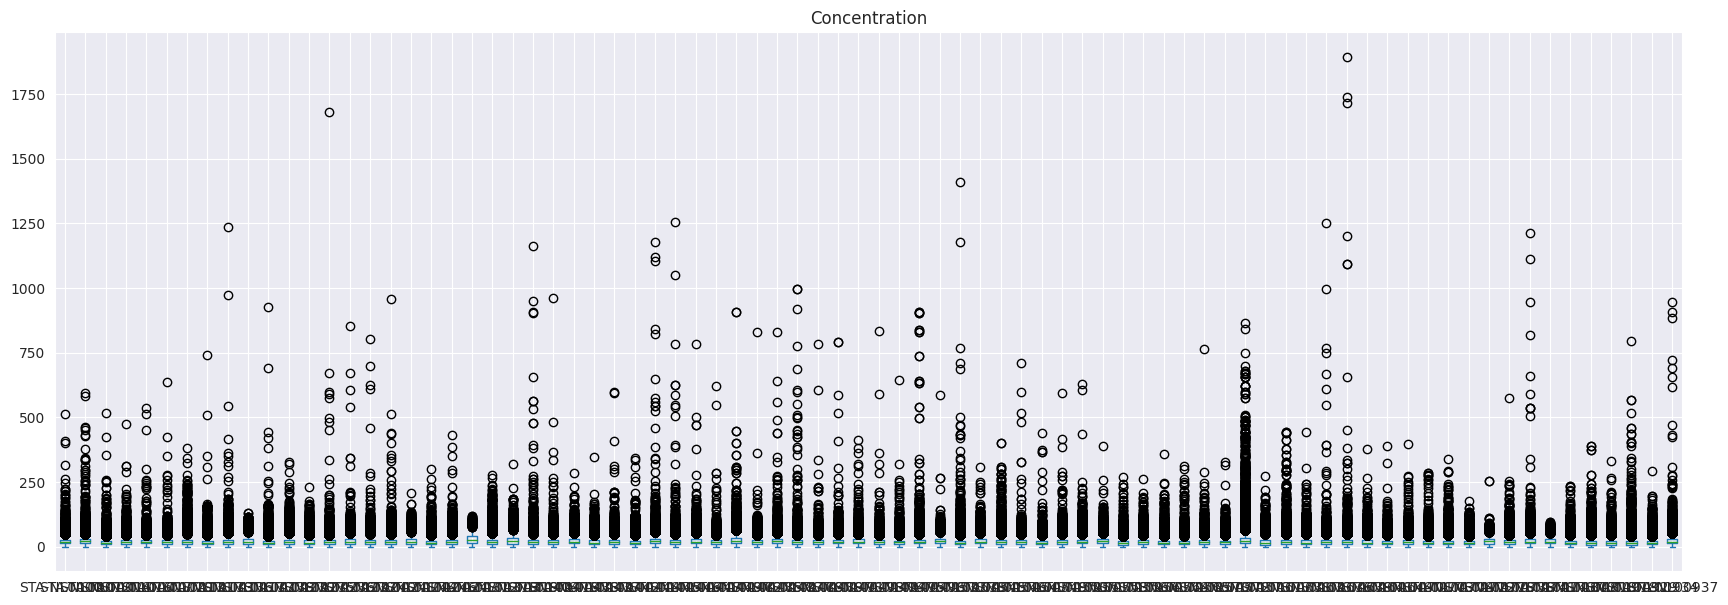

--------------------------------------------POLLUTANT CO--------------------------------------------



count    750681.000000
mean          0.314386
std           0.177855
min           0.000300
25%           0.208000
50%           0.276000
75%           0.370000
max           8.583000
Name: Concentration, dtype: float64

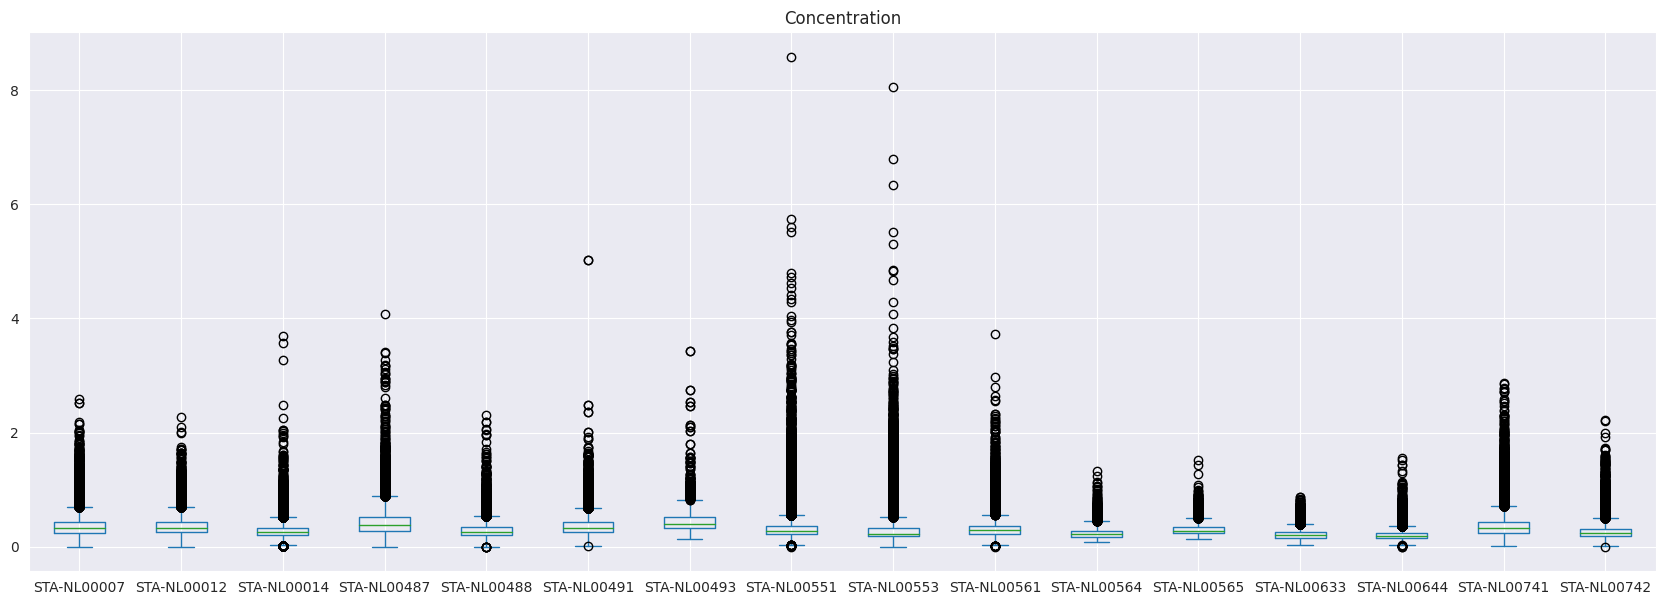

--------------------------------------------POLLUTANT SO2--------------------------------------------



count    935280.000000
mean          3.300113
std           6.073747
min           0.010000
25%           0.640000
50%           1.620000
75%           3.800000
max         707.300000
Name: Concentration, dtype: float64

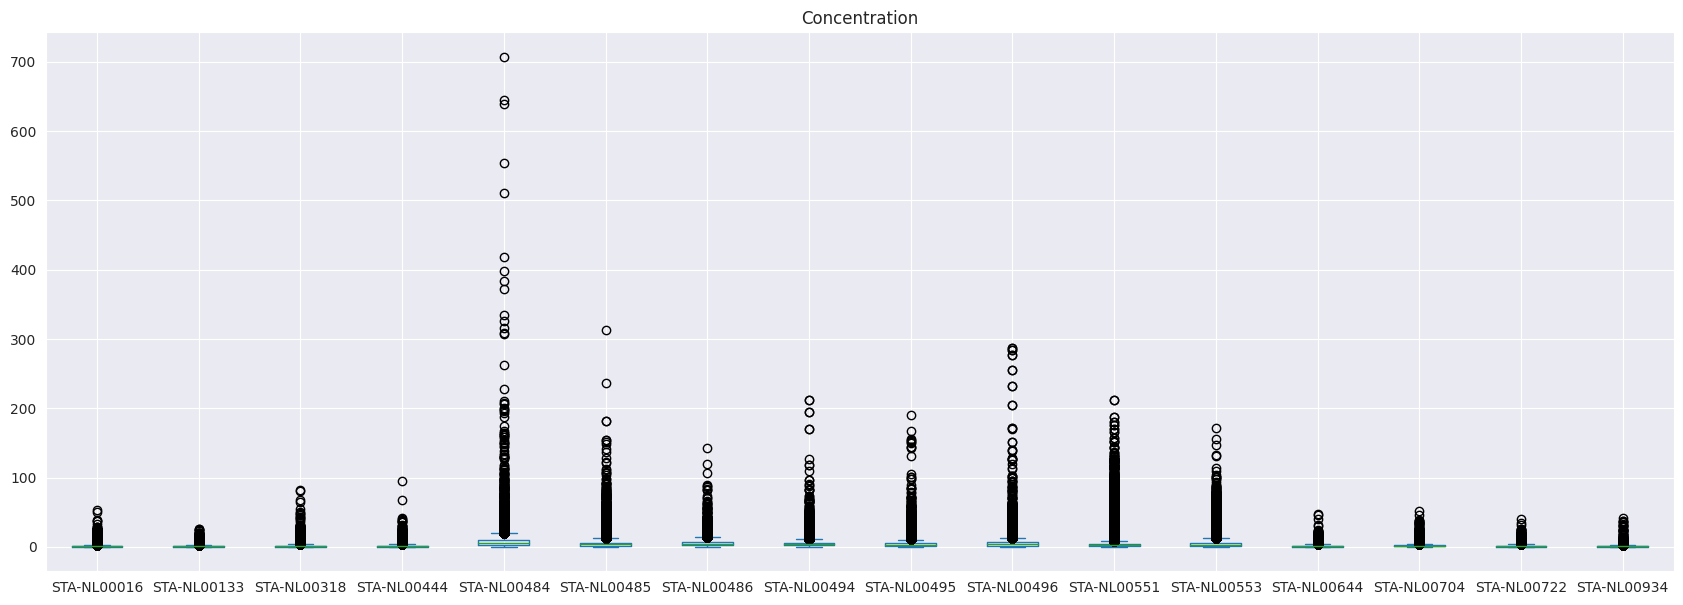

--------------------------------------------POLLUTANT NO2--------------------------------------------



count    3.702699e+06
mean     2.559406e+01
std      1.910350e+01
min      1.000000e-02
25%      1.100000e+01
50%      2.066000e+01
75%      3.570000e+01
max      6.042000e+02
Name: Concentration, dtype: float64

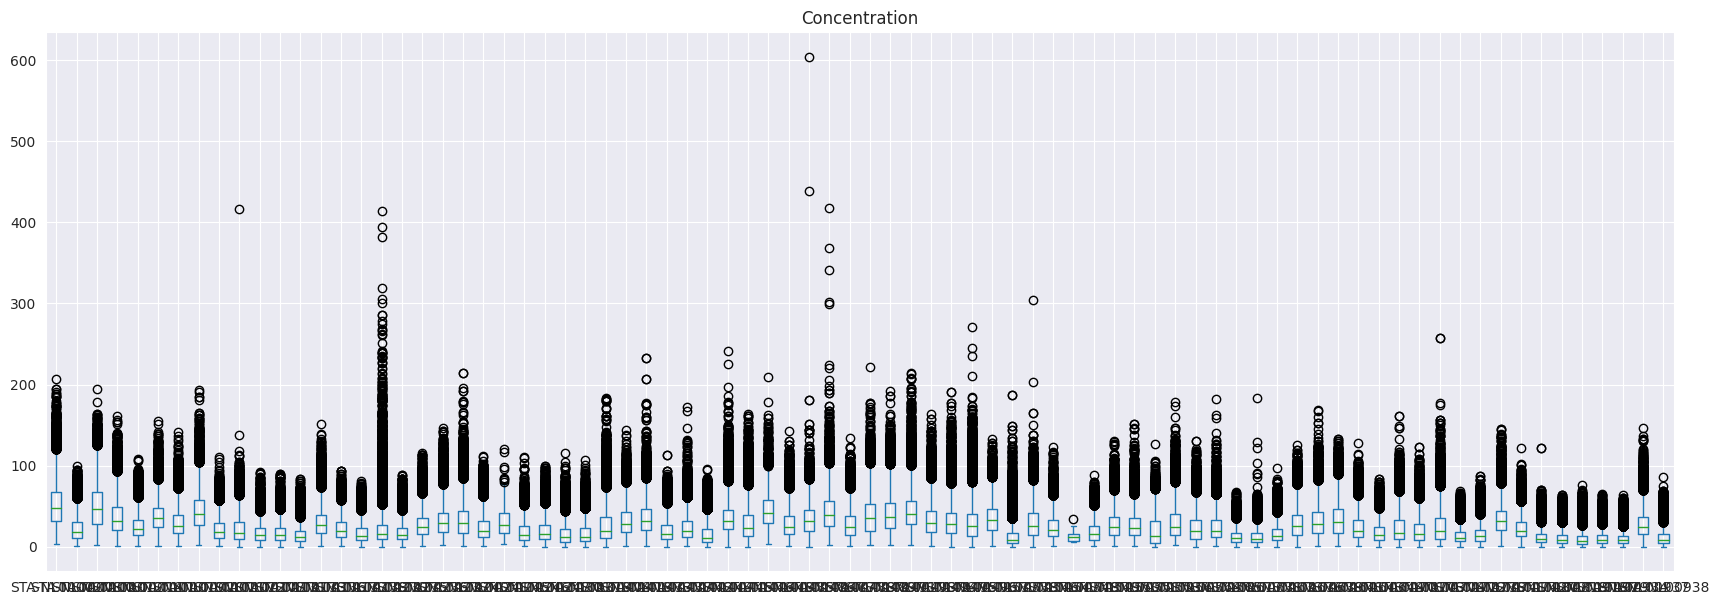

In [16]:
for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    print()
    display(df_list[i]['Concentration'].describe())
    df_list[i].plot.box(column="Concentration", by="AirQualityStation", figsize=(21, 7))
    plt.show()

##### Оценка выбросов

In [17]:
def get_outliers(frame):
    series = frame['Concentration']
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    mask = (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))
    return frame[mask]

In [18]:
pol_stations = dict()
for i in range(len(POL_CODES)):
    pol_stations[POL_CODES[i]] = df_list[i]['AirQualityStation'].unique()

In [19]:
print(f'Доля выбросов в выборке по загрязнителям')
pol_outliers = dict()
for i in range(len(POL_CODES)):
    outliers = pd.DataFrame()
    for station in pol_stations[POL_CODES[i]]:
        outliers_per_station = get_outliers(df_list[i][df_list[i]['AirQualityStation'] == station])
        outliers = pd.concat([outliers, outliers_per_station], ignore_index=True, axis=0)
    pol_outliers[POL_CODES[i]] = outliers
    outliers_all = get_outliers(df_list[i])
    print(f'    Загрязнитель: {POL_NAMES[POL_CODES[i]]} - {round(outliers.shape[0]/df_list[i].shape[0]*100, 2)}% - по станциям, {round(outliers_all.shape[0]/df_list[i].shape[0]*100, 2)}% - вместе')

Доля выбросов в выборке по загрязнителям
    Загрязнитель: O3 - 1.16% - по станциям, 1.09% - вместе
    Загрязнитель: PM2.5 - 6.06% - по станциям, 5.92% - вместе
    Загрязнитель: PM10 - 4.32% - по станциям, 4.16% - вместе
    Загрязнитель: CO - 4.88% - по станциям, 4.86% - вместе
    Загрязнитель: SO2 - 7.26% - по станциям, 8.18% - вместе
    Загрязнитель: NO2 - 2.56% - по станциям, 2.53% - вместе


##### Анализ распределения концентраций в рамках станций

--------------------------------------------POLLUTANT O3--------------------------------------------



count    3.402877e+06
mean     4.550108e+01
std      2.692134e+01
min      1.000000e-02
25%      2.560000e+01
50%      4.554000e+01
75%      6.288000e+01
max      2.789600e+02
Name: Concentration, dtype: float64


Станции: ['STA-NL00446' 'STA-NL00631' 'STA-NL00442' 'STA-NL00235' 'STA-NL00437'
 'STA-NL00494' 'STA-NL00137' 'STA-NL00138' 'STA-NL00433' 'STA-NL00807'
 'STA-NL00301' 'STA-NL00644' 'STA-NL00236' 'STA-NL00538' 'STA-NL00633'
 'STA-NL00014' 'STA-NL00485' 'STA-NL00131' 'STA-NL00404' 'STA-NL00641'
 'STA-NL00107' 'STA-NL00489' 'STA-NL00133' 'STA-NL00247' 'STA-NL00449'
 'STA-NL00230' 'STA-NL00643' 'STA-NL00742' 'STA-NL00639' 'STA-NL00934'
 'STA-NL00493' 'STA-NL00918' 'STA-NL00929' 'STA-NL00550' 'STA-NL00722'
 'STA-NL00012' 'STA-NL00938' 'STA-NL00418' 'STA-NL00564' 'STA-NL00318'
 'STA-NL00003' 'STA-NL00496' 'STA-NL00495' 'STA-NL00241' 'STA-NL00617'
 'STA-NL00738' 'STA-NL00444' 'STA-NL00636' 'STA-NL00818' 'STA-NL00701'
 'STA-NL00537']


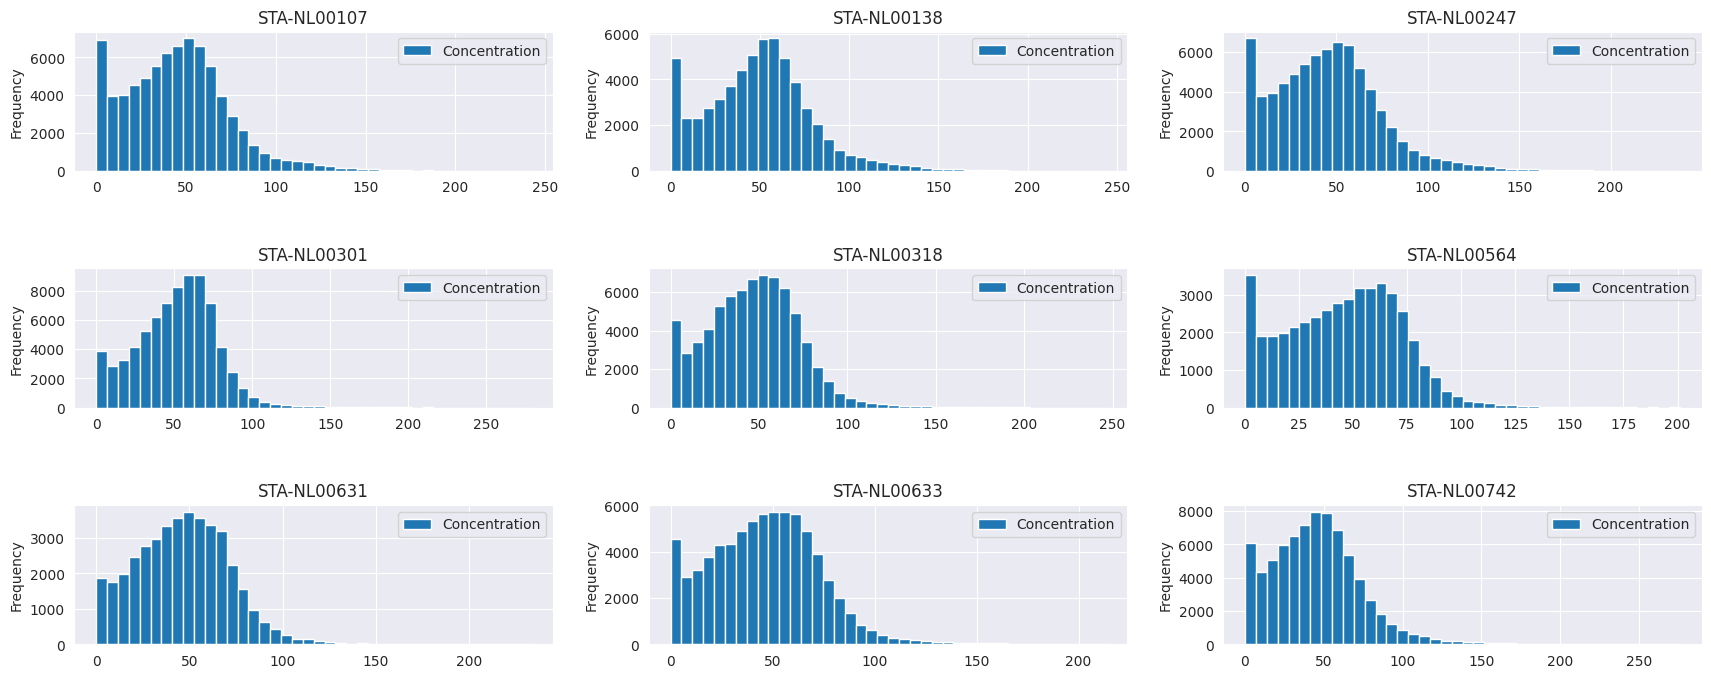

--------------------------------------------POLLUTANT PM2.5--------------------------------------------



count    2.883292e+06
mean     1.238830e+01
std      1.145941e+01
min      5.000000e-04
25%      5.400000e+00
50%      9.100000e+00
75%      1.599600e+01
max      1.558080e+03
Name: Concentration, dtype: float64


Станции: ['STA-NL00496' 'STA-NL00491' 'STA-NL00494' 'STA-NL00017' 'STA-NL00241'
 'STA-NL00136' 'STA-NL00561' 'STA-NL00489' 'STA-NL00131' 'STA-NL00433'
 'STA-NL00641' 'STA-NL00485' 'STA-NL00247' 'STA-NL00643' 'STA-NL00570'
 'STA-NL00240' 'STA-NL00014' 'STA-NL00937' 'STA-NL00551' 'STA-NL00547'
 'STA-NL00404' 'STA-NL00553' 'STA-NL00938' 'STA-NL00701' 'STA-NL00738'
 'STA-NL00488' 'STA-NL00644' 'STA-NL00741' 'STA-NL00495' 'STA-NL00444'
 'STA-NL00138' 'STA-NL00703' 'STA-NL00482' 'STA-NL00538' 'STA-NL00487'
 'STA-NL00449' 'STA-NL00704' 'STA-NL00934' 'STA-NL00007' 'STA-NL00573'
 'STA-NL00556' 'STA-NL00821' 'STA-NL00742' 'STA-NL00230' 'STA-NL00418'
 'STA-NL00448' 'STA-NL00636' 'STA-NL00016' 'STA-NL00012' 'STA-NL00572']


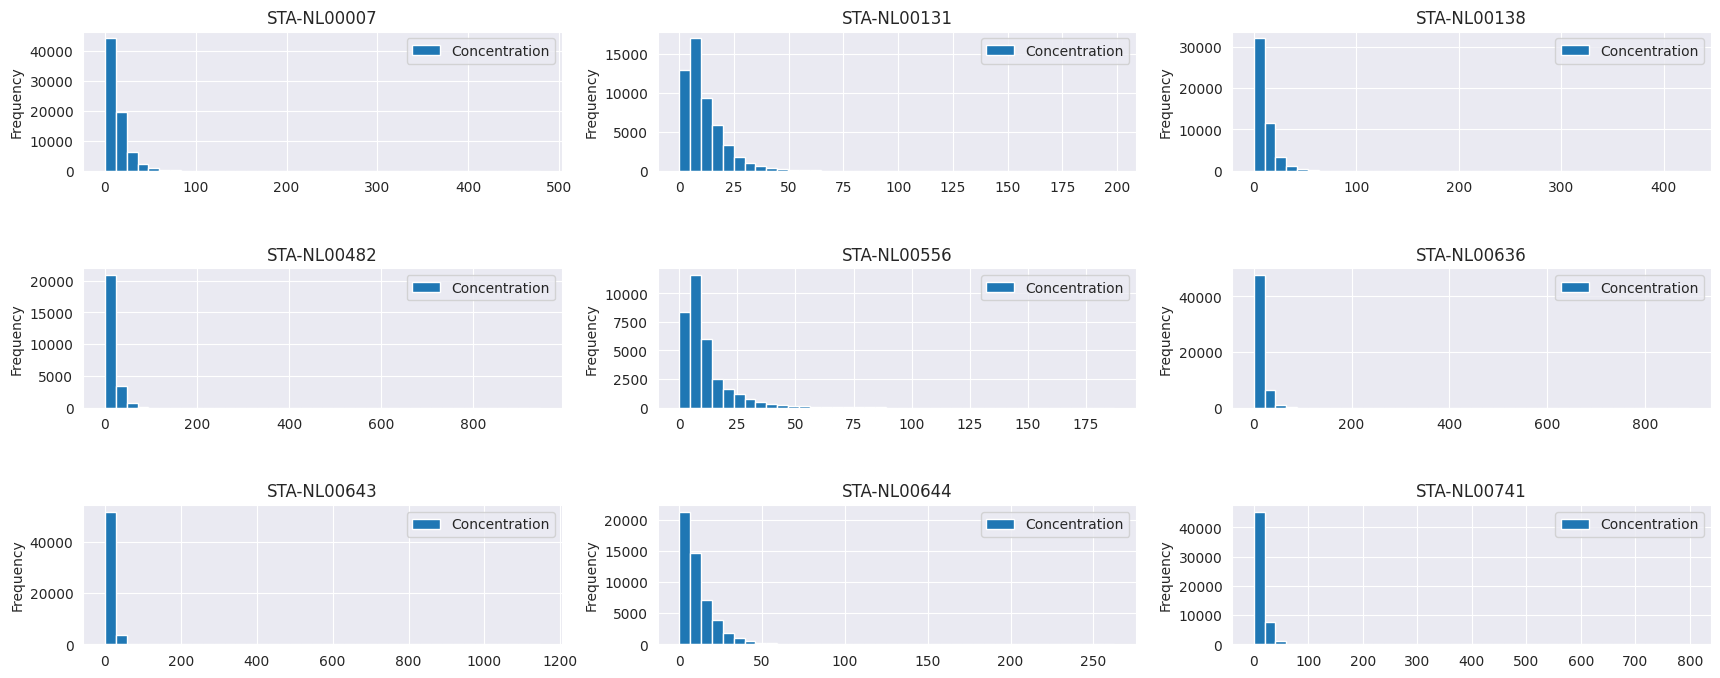

--------------------------------------------POLLUTANT PM10--------------------------------------------



count    5.076520e+06
mean     2.047814e+01
std      1.496572e+01
min      2.000000e-03
25%      1.100000e+01
50%      1.739000e+01
75%      2.619000e+01
max      1.893710e+03
Name: Concentration, dtype: float64


Станции: ['STA-NL00012' 'STA-NL00488' 'STA-NL00538' 'STA-NL00494' 'STA-NL00236'
 'STA-NL00447' 'STA-NL00318' 'STA-NL00556' 'STA-NL00644' 'STA-NL00136'
 'STA-NL00918' 'STA-NL00246' 'STA-NL00573' 'STA-NL00495' 'STA-NL00131'
 'STA-NL00550' 'STA-NL00487' 'STA-NL00807' 'STA-NL00636' 'STA-NL00485'
 'STA-NL00017' 'STA-NL00016' 'STA-NL00738' 'STA-NL00545' 'STA-NL00631'
 'STA-NL00007' 'STA-NL00446' 'STA-NL00240' 'STA-NL00572' 'STA-NL00633'
 'STA-NL00491' 'STA-NL00722' 'STA-NL00137' 'STA-NL00489' 'STA-NL00241'
 'STA-NL00437' 'STA-NL00565' 'STA-NL00442' 'STA-NL00496' 'STA-NL00703'
 'STA-NL00639' 'STA-NL00444' 'STA-NL00701' 'STA-NL00235' 'STA-NL00537'
 'STA-NL00247' 'STA-NL00230' 'STA-NL00445' 'STA-NL00937' 'STA-NL00570'
 'STA-NL00934' 'STA-NL00014' 'STA-NL00138' 'STA-NL00617' 'STA-NL00418'
 'STA-NL00553' 'STA-NL00551' 'STA-NL00433' 'STA-NL00133' 'STA-NL00547'
 'STA-NL00449' 'STA-NL00493' 'STA-NL00404' 'STA-NL00929' 'STA-NL00549'
 'STA-NL00237' 'STA-NL00020' 'STA-NL00641' 'STA-NL00546' 'STA-NL002

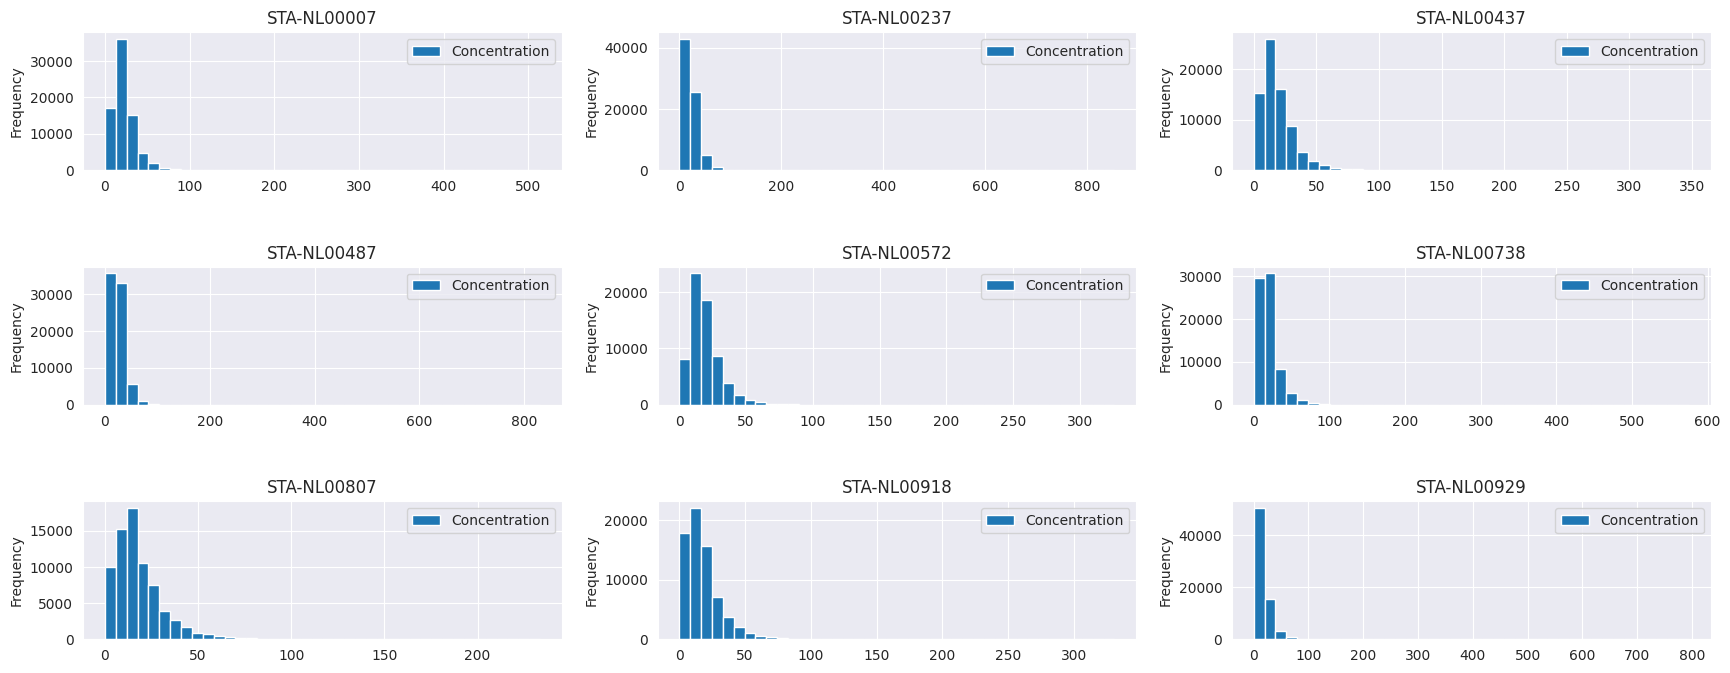

--------------------------------------------POLLUTANT CO--------------------------------------------



count    750681.000000
mean          0.314386
std           0.177855
min           0.000300
25%           0.208000
50%           0.276000
75%           0.370000
max           8.583000
Name: Concentration, dtype: float64


Станции: ['STA-NL00742' 'STA-NL00012' 'STA-NL00551' 'STA-NL00553' 'STA-NL00644'
 'STA-NL00633' 'STA-NL00487' 'STA-NL00561' 'STA-NL00488' 'STA-NL00741'
 'STA-NL00014' 'STA-NL00491' 'STA-NL00007' 'STA-NL00565' 'STA-NL00493'
 'STA-NL00564']


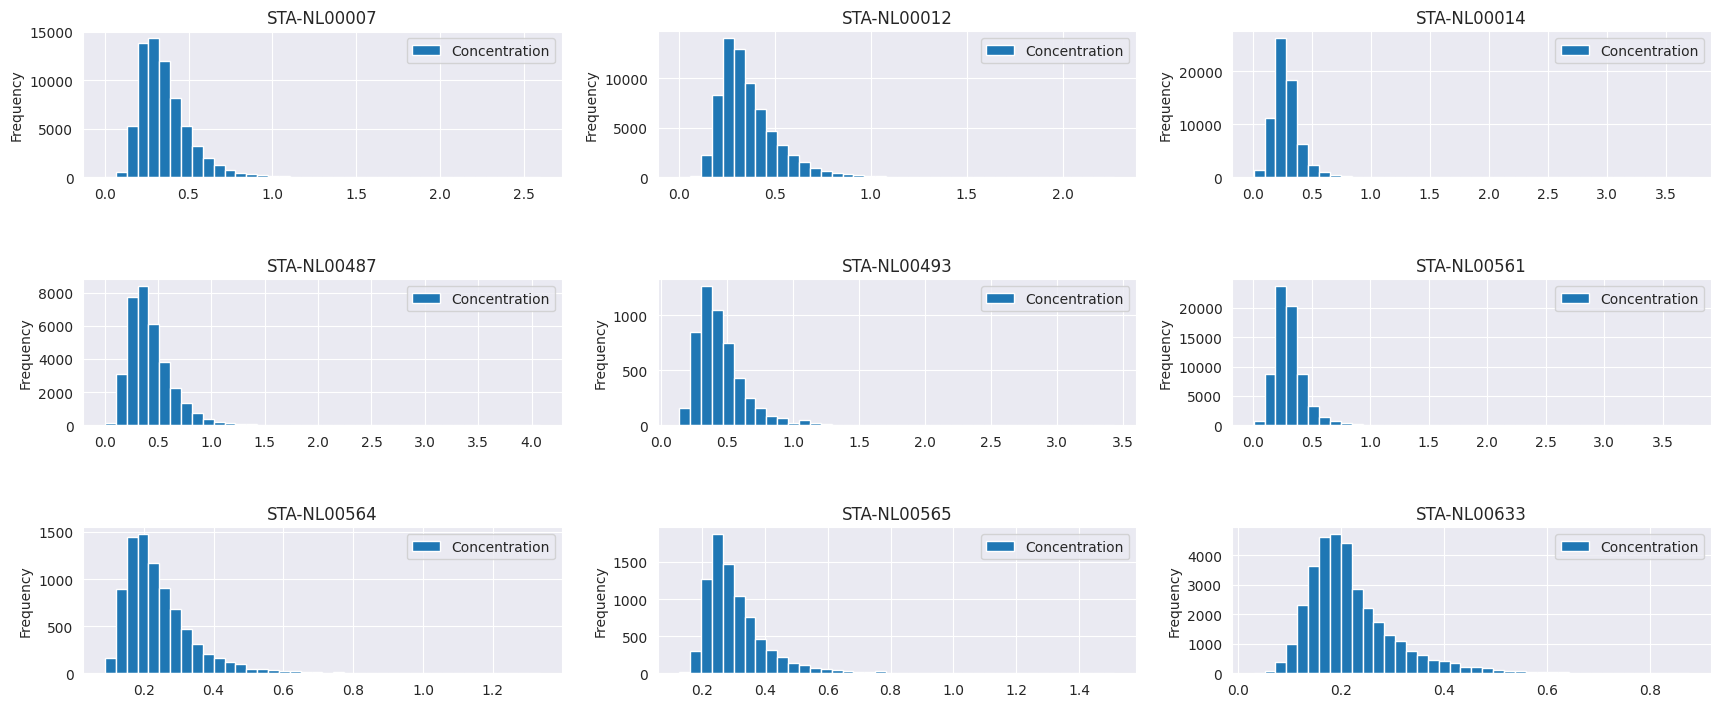

--------------------------------------------POLLUTANT SO2--------------------------------------------



count    935280.000000
mean          3.300113
std           6.073747
min           0.010000
25%           0.640000
50%           1.620000
75%           3.800000
max         707.300000
Name: Concentration, dtype: float64


Станции: ['STA-NL00553' 'STA-NL00444' 'STA-NL00133' 'STA-NL00644' 'STA-NL00485'
 'STA-NL00496' 'STA-NL00318' 'STA-NL00934' 'STA-NL00486' 'STA-NL00722'
 'STA-NL00494' 'STA-NL00016' 'STA-NL00484' 'STA-NL00551' 'STA-NL00495'
 'STA-NL00704']


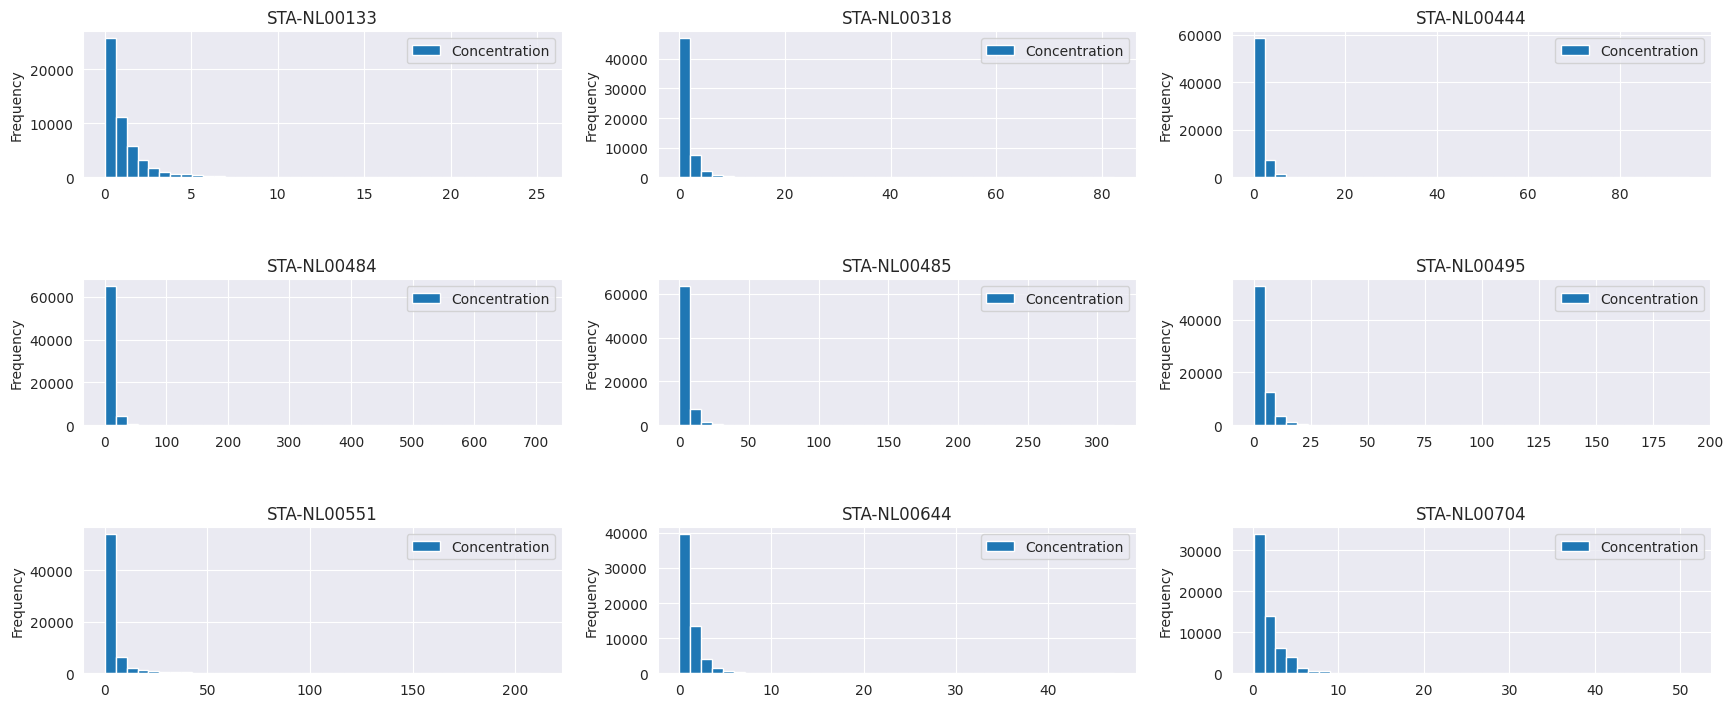

--------------------------------------------POLLUTANT NO2--------------------------------------------



count    3.702699e+06
mean     2.559406e+01
std      1.910350e+01
min      1.000000e-02
25%      1.100000e+01
50%      2.066000e+01
75%      3.570000e+01
max      6.042000e+02
Name: Concentration, dtype: float64


Станции: ['STA-NL00643' 'STA-NL00546' 'STA-NL00547' 'STA-NL00722' 'STA-NL00564'
 'STA-NL00553' 'STA-NL00636' 'STA-NL00633' 'STA-NL00639' 'STA-NL00703'
 'STA-NL00742' 'STA-NL00485' 'STA-NL00240' 'STA-NL00551' 'STA-NL00418'
 'STA-NL00235' 'STA-NL00442' 'STA-NL00937' 'STA-NL00446' 'STA-NL00003'
 'STA-NL00020' 'STA-NL00741' 'STA-NL00494' 'STA-NL00641' 'STA-NL00493'
 'STA-NL00433' 'STA-NL00561' 'STA-NL00496' 'STA-NL00237' 'STA-NL00107'
 'STA-NL00486' 'STA-NL00247' 'STA-NL00444' 'STA-NL00246' 'STA-NL00318'
 'STA-NL00491' 'STA-NL00565' 'STA-NL00934' 'STA-NL00495' 'STA-NL00012'
 'STA-NL00241' 'STA-NL00007' 'STA-NL00445' 'STA-NL00487' 'STA-NL00136'
 'STA-NL00138' 'STA-NL00002' 'STA-NL00301' 'STA-NL00918' 'STA-NL00488'
 'STA-NL00549' 'STA-NL00537' 'STA-NL00704' 'STA-NL00701' 'STA-NL00938'
 'STA-NL00818' 'STA-NL00022' 'STA-NL00021' 'STA-NL00133' 'STA-NL00489'
 'STA-NL00019' 'STA-NL00131' 'STA-NL00929' 'STA-NL00014' 'STA-NL00437'
 'STA-NL00017' 'STA-NL00550' 'STA-NL00644' 'STA-NL00807' 'STA-NL007

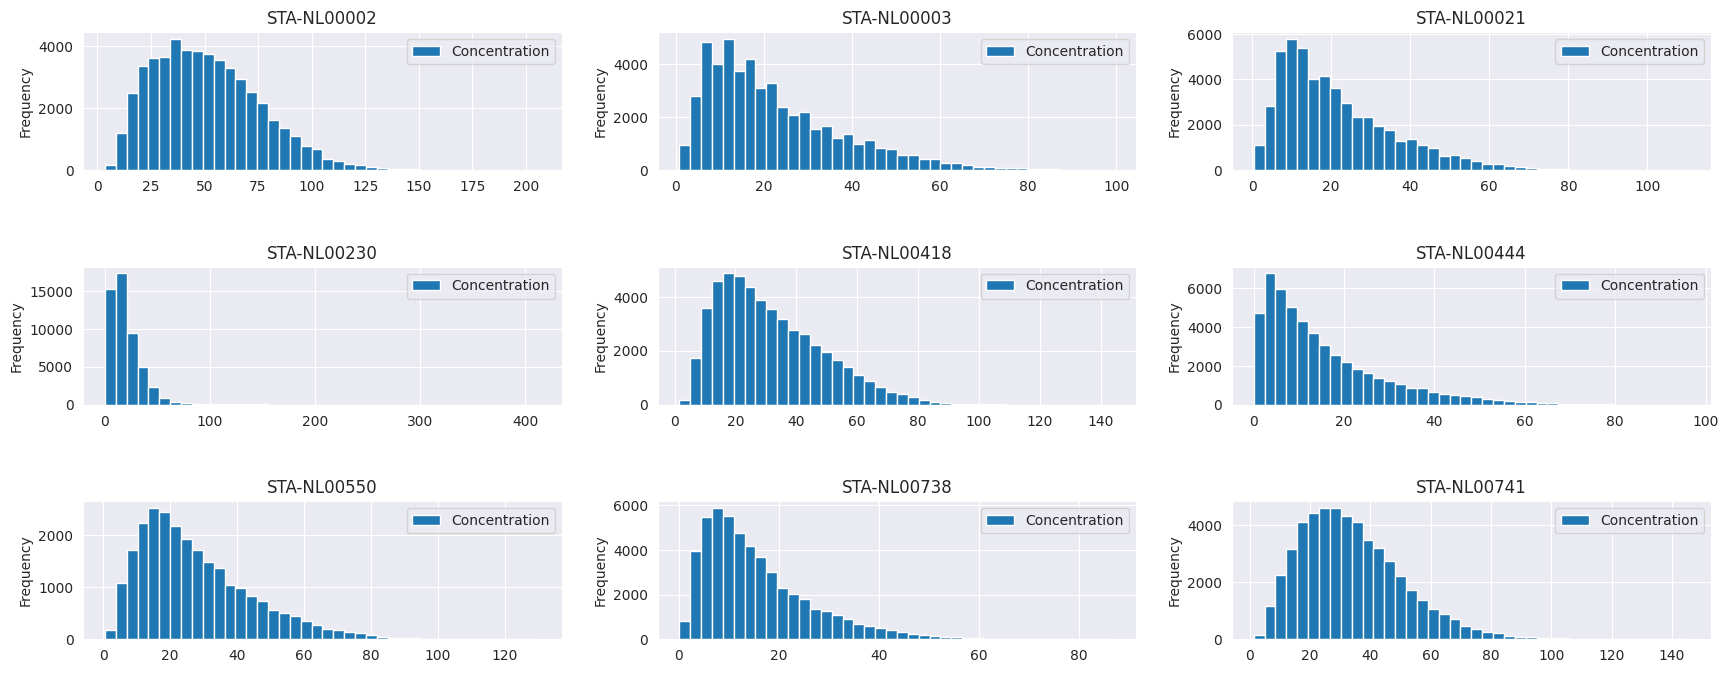

In [20]:
PLOTS_IN_LINE = 3

for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    print()
    display(df_list[i]['Concentration'].describe())
    stations = df_list[i]['AirQualityStation'].unique()
    print()
    #print(f'Станции: {stations}')
    df_list[i].reset_index(inplace=True, drop=True)
    plots_lines_count = math.ceil(len(stations)/PLOTS_IN_LINE)
    some_rand_stat = stations[np.random.choice(len(stations), size=min(len(stations), 6), replace=False)]
    df_list[i][df_list[i]['AirQualityStation'].isin(some_rand_stat)].plot.hist(column=["Concentration"], by="AirQualityStation", figsize=(21, 3*plots_lines_count), bins=40, subplots=True, layout=(plots_lines_count, PLOTS_IN_LINE))
    plt.subplots_adjust(hspace=0.7)
    plt.show()

<a id="outliers_conc"></a>
**Выводы:**
1. Имеются существенные (на 1-2 порядка) выбросы по всем загрязнителям. Но таких выбросов не много и они соответствуют всего нескольким станциям.
2. Наиболее значительны выбросы у PM2.5, PM10, SO2 (на 2 порядка). Данные загрязнители являются продуктом работы индустриальных предприятий и вполне могут соответствовать реальным значениям, связанным с нештатными ситуациями. Их необходимо учитывать и рассмотреть отдельно.
3. Для PM2.5 и SO2 доля выбросов максимальна и составляет более 6%. Для О3 - минимальна, менее 1%.
4. Различия между расчетом выбросов в разрезе станций и без несущественны.
5. Как правило, концентрации в разрезе станций имеют положительно скошенное распределение с одним пиком. Значения среднего и медианы близки, медиана немного меньше.
6. У О3 имеется второй пик вблизи нуля. Надо разобраться, о чем это может свидетельствовать.

<a id="ts_main"></a>
***
#### Временные ряды концентраций загрязнителей
***

##### Подготовка dataframe с усредненными по станциям концентрациями на каждый час. Загрязнители сгруппированы по столбцам одного dataframe

In [21]:
df_mean_list = list()
for i in range(len(POL_CODES)):
    df_mean_list.append(df_list[i].groupby('DatetimeEnd', as_index=False)['Concentration'].mean())
    df_mean_list[i].rename(columns={'Concentration': POL_NAMES[POL_CODES[i]]}, inplace=True)

df_ts = reduce(lambda df1, df2: df1.merge(df2, how='outer', left_on=['DatetimeEnd'], right_on=['DatetimeEnd']), df_mean_list)
#df_ts.reset_index(drop=True, inplace=True)
print(df_ts.shape[0])
df_ts.head()

70128


,DatetimeEnd,O3,PM2.5,PM10,CO,SO2,NO2
0,2013-01-01 01:00:00+01:00,52.147174,100.810000,143.181521,0.310870,5.892727,18.144539
1,2013-01-01 02:00:00+01:00,53.285870,41.575238,47.030726,0.308304,4.936364,14.554255
2,2013-01-01 03:00:00+01:00,54.648140,17.358571,20.219764,0.289609,4.407273,13.046099
3,2013-01-01 04:00:00+01:00,55.068182,12.400952,14.028471,0.280174,3.634167,13.544397
4,2013-01-01 05:00:00+01:00,53.998667,9.770000,12.923681,0.268565,3.339167,13.665036


##### Отображение временных рядов по загрязнителям

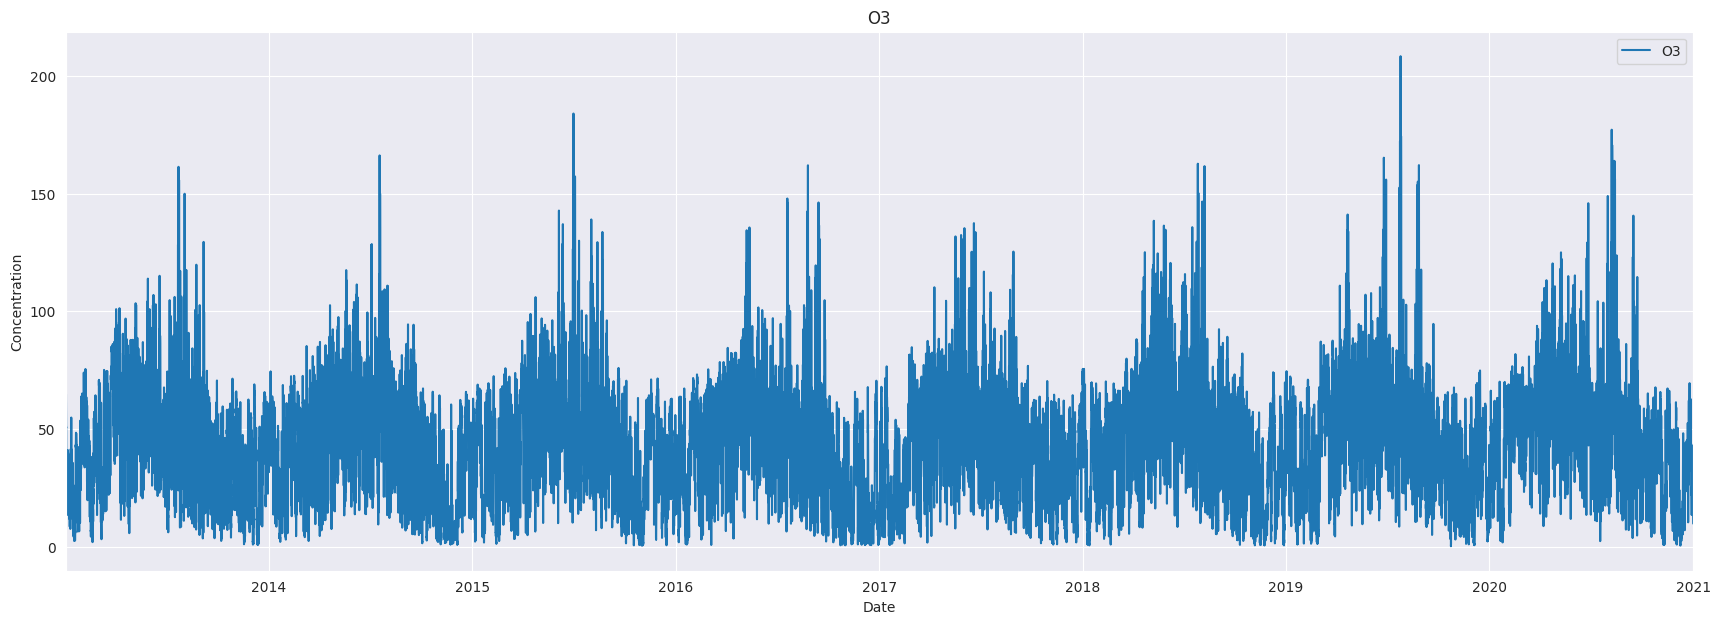

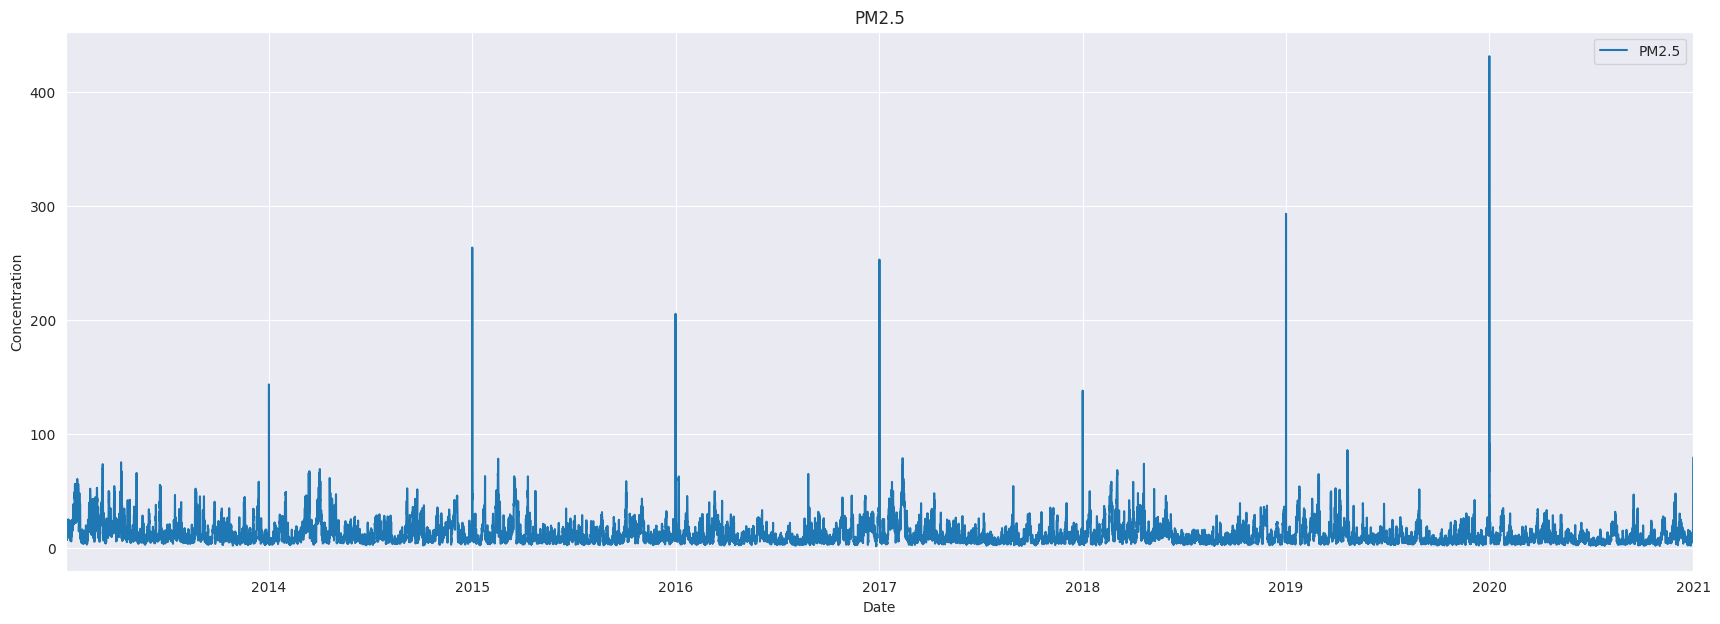

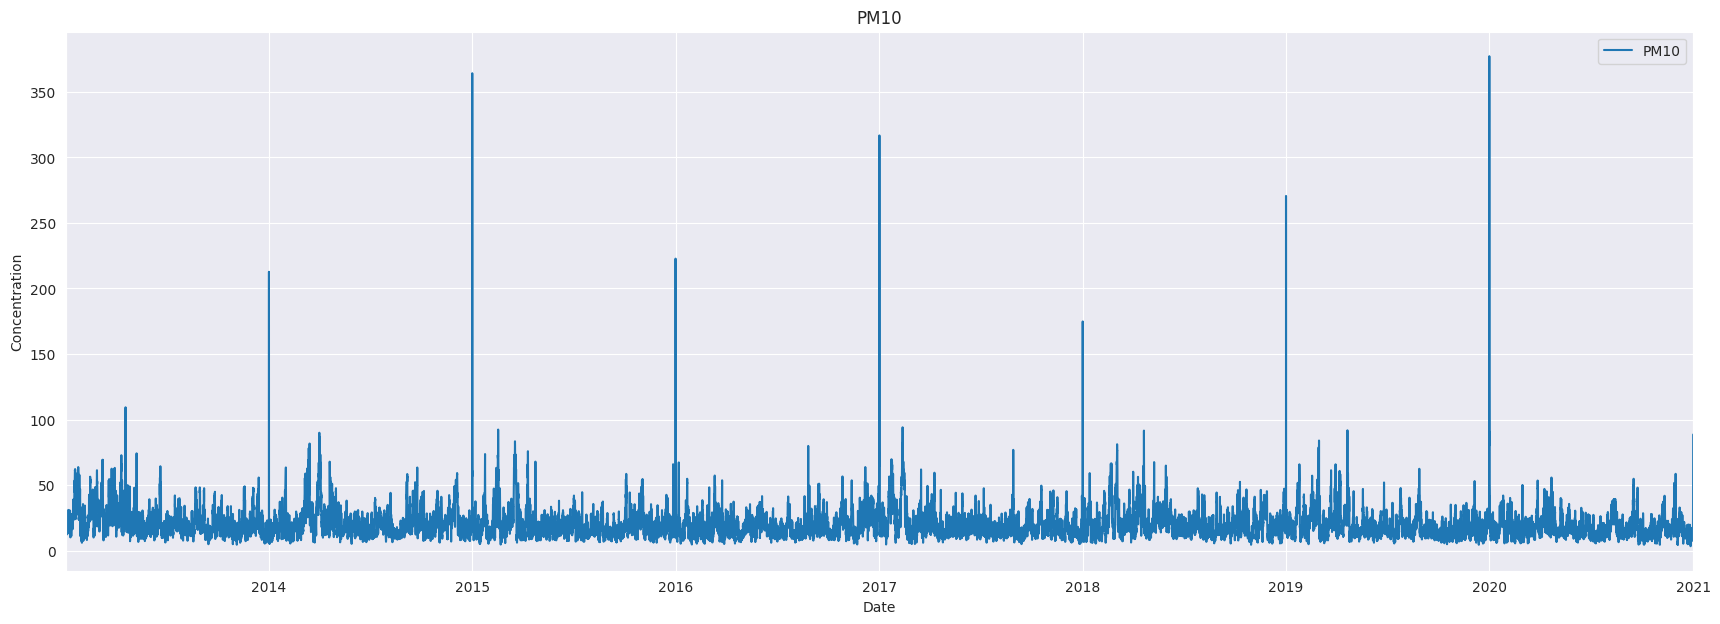

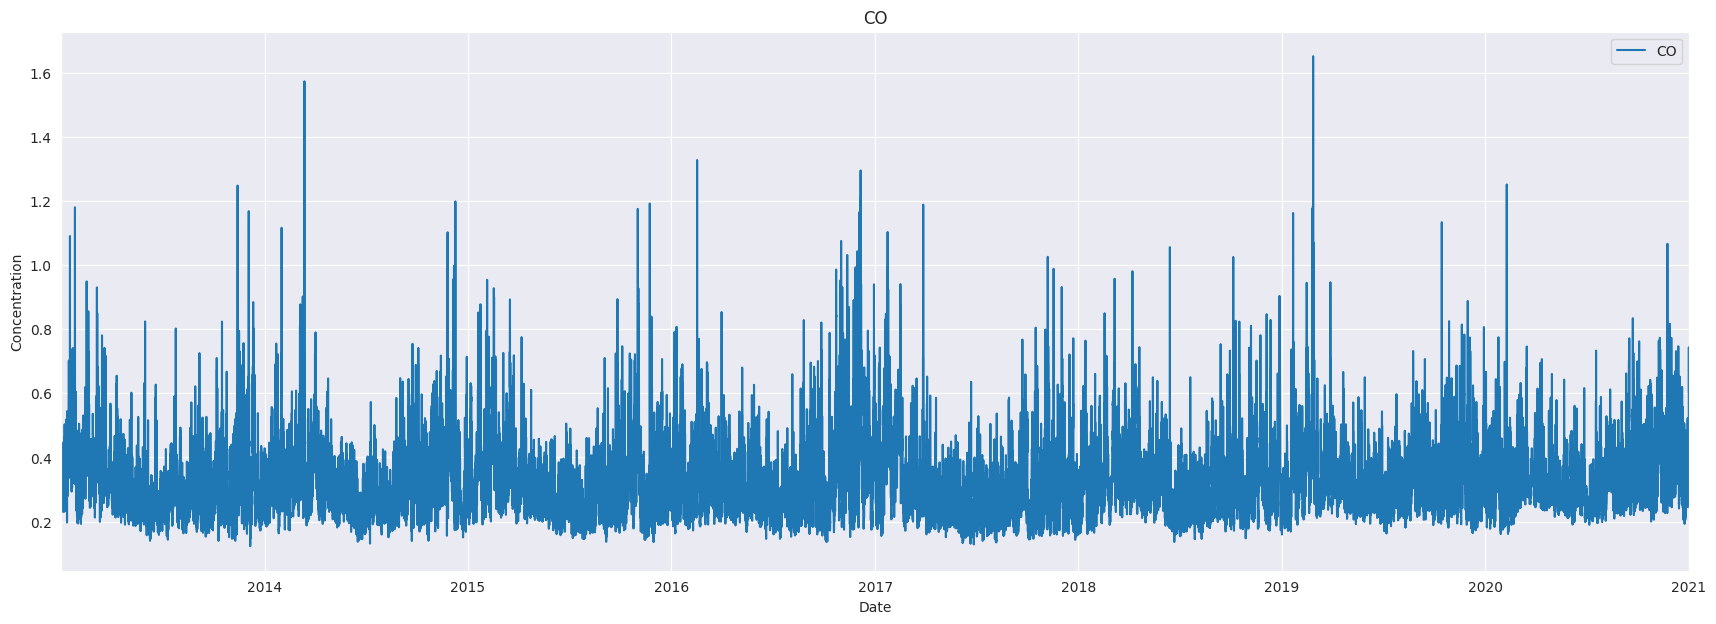

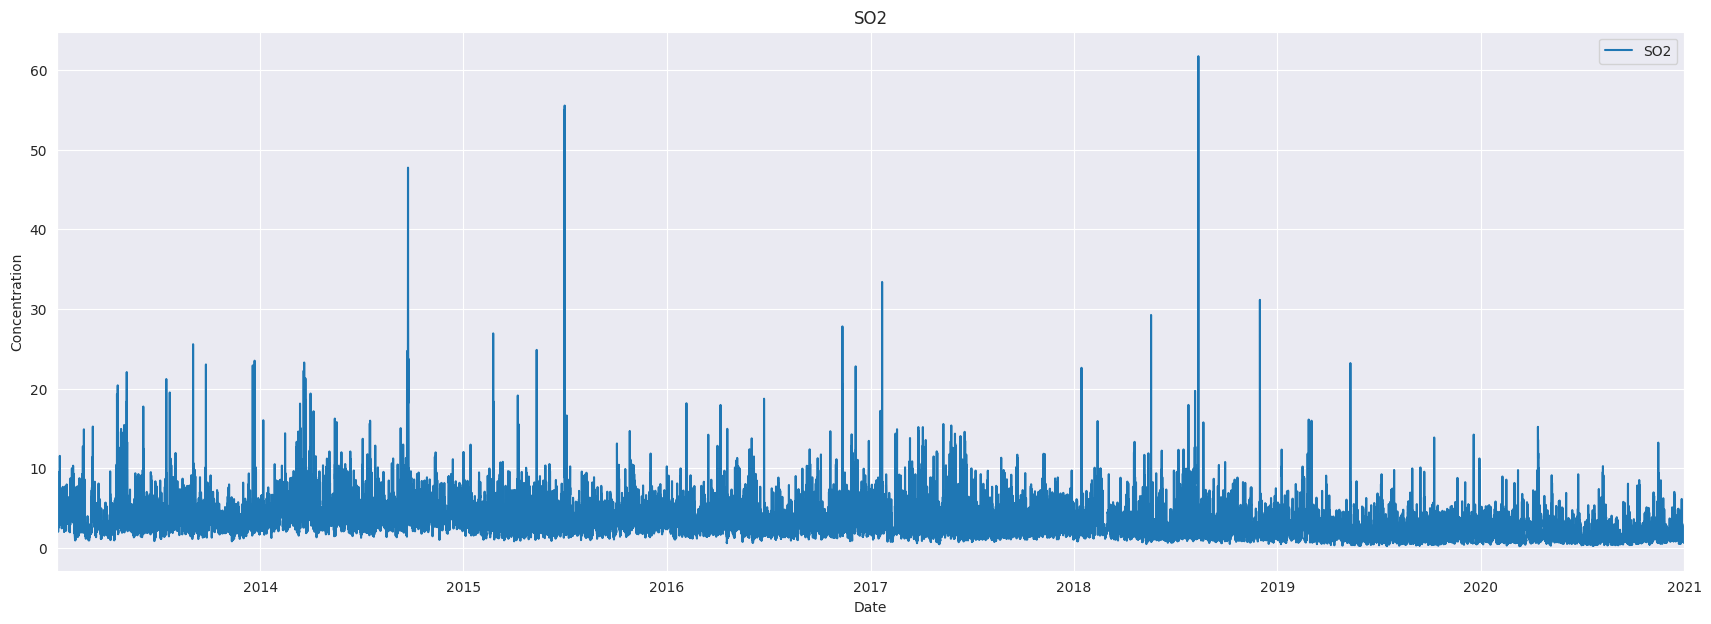

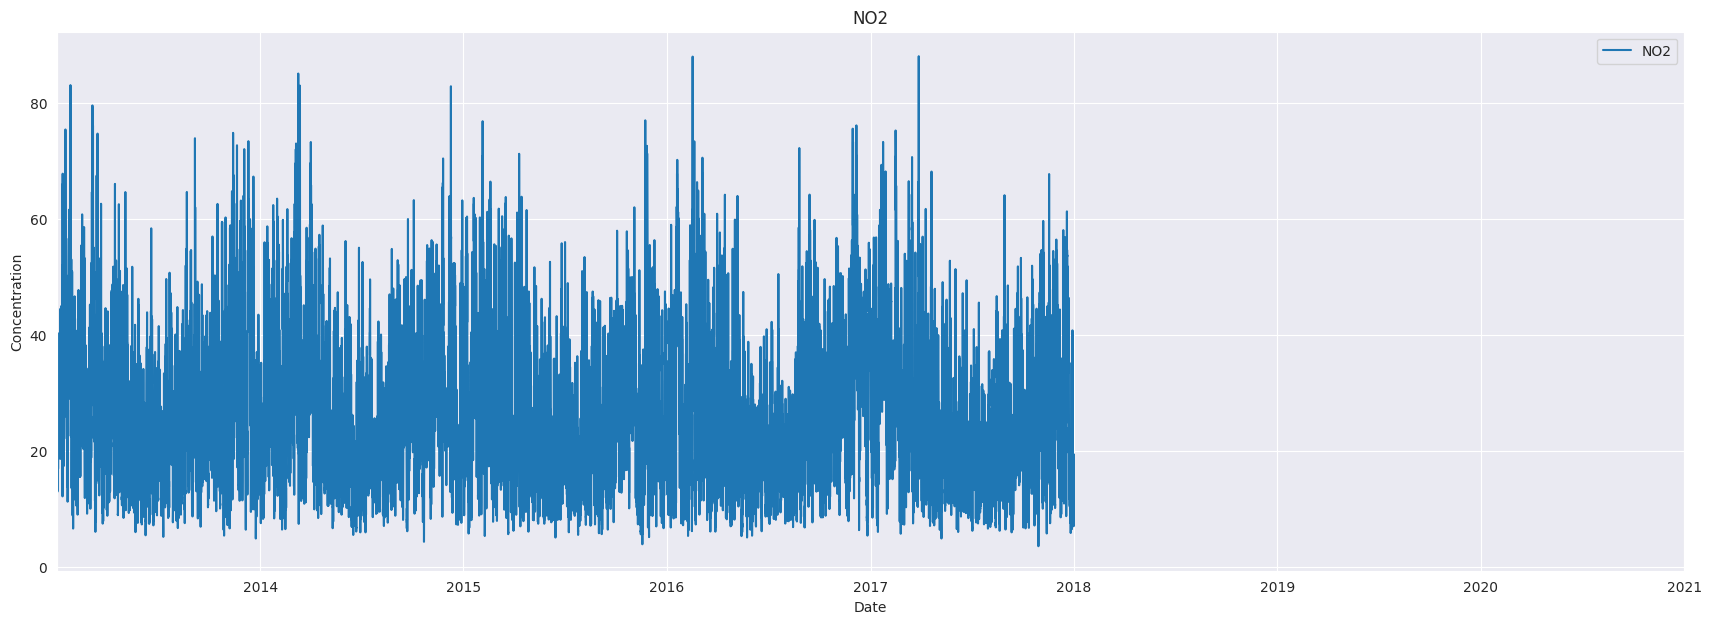

In [22]:
#fig, axs = plt.subplots(len(POL_CODES), figsize=(25, 7 * len(POL_CODES)))
for i in range(len(POL_CODES)):
    pol = POL_NAMES[POL_CODES[i]]
    #.plot(x='DatetimeEnd', xlabel="Date", ylabel="Concentration", title=pol_code, y=pol_code, figsize=(21,7), ax=plt.gca())
    df_ts.plot(x='DatetimeEnd', xlabel="Date", ylabel="Concentration", title=pol,  y=pol, c='tab:blue', figsize=(21,7), ax=plt.gca())
    plt.show()

<a id="ts_main_conc"></a>
*Выводы:*
1. На графике концентрации О3 видна сезонность с пиками летом и минимума зимой. Вероятно это связано с механизмом образования О3 через NOx соединения, которые могут выделяться при аграрных процессах и вегетационных процессах, которые преимущественно приходятся на лето и высокие температуры. Также на лето приходятся выбросы, непонятно, с чем это связано.
2. На графике концентрации PM2.5 также видна сезонность, но видна не так явно, требуется проверка. Небольшой подъем приходится на начало года. Поскольку PM2.5 активно выделяется при сжигании топлива, то повышенные концентрации могут быть связаны с активным отопительным сезоном, т.е. с периодами низких температур. Так же четко на начало каждого года приходятся огромные выбросы. Это странно, возможно эти данные невалидны. Требуется проверка
3. График концентрации PM10 очень похож на график PM2.5, что и понятно, потому что эти загрязнители производятся одними и теми же технологическими и природными процессами. Но для PM10 есть дополнительные огромные выбросы, непонятно с чем связаны.
4. График концентрации CO также на первый взгляд имеет сезонность с подъемами зимой и спадами летом. Вероятно это связано с более активным сжиганием топлива в отопительные сезоны.
5. График концентрации SO2 имеет убывающий тренд. Кажется, что есть некоторая сезонность с повышением концентрации летом. Непонятно, как такое может быть, с учетом того, что летом менее активны процессы сжигания топлива. Нужен более детальный анализ временного ряда. Возможно есть тренд на небольшое снижение концентраций SO2, но это требует проверки.
6. На график концентрации NO2 видно, что выбросы невелики. Это можно объяснить тем, что основным источником NO2 являются дизельные двигатели и ситуаций, когда их начианют резко использользовать намного больше обычного, пожалуй, не бывает. Возможно есть сезонность с подъемом зимой и спуском летом, что можно также объяснить особенностями работы двигателей при низких температурах. Данных после 2018 года нет, надо проверить, корректно ли была выполнена загрузка данных.


<a id="pol_cor"></a>
***
#### Анализ корреляций между загрязнителями
***

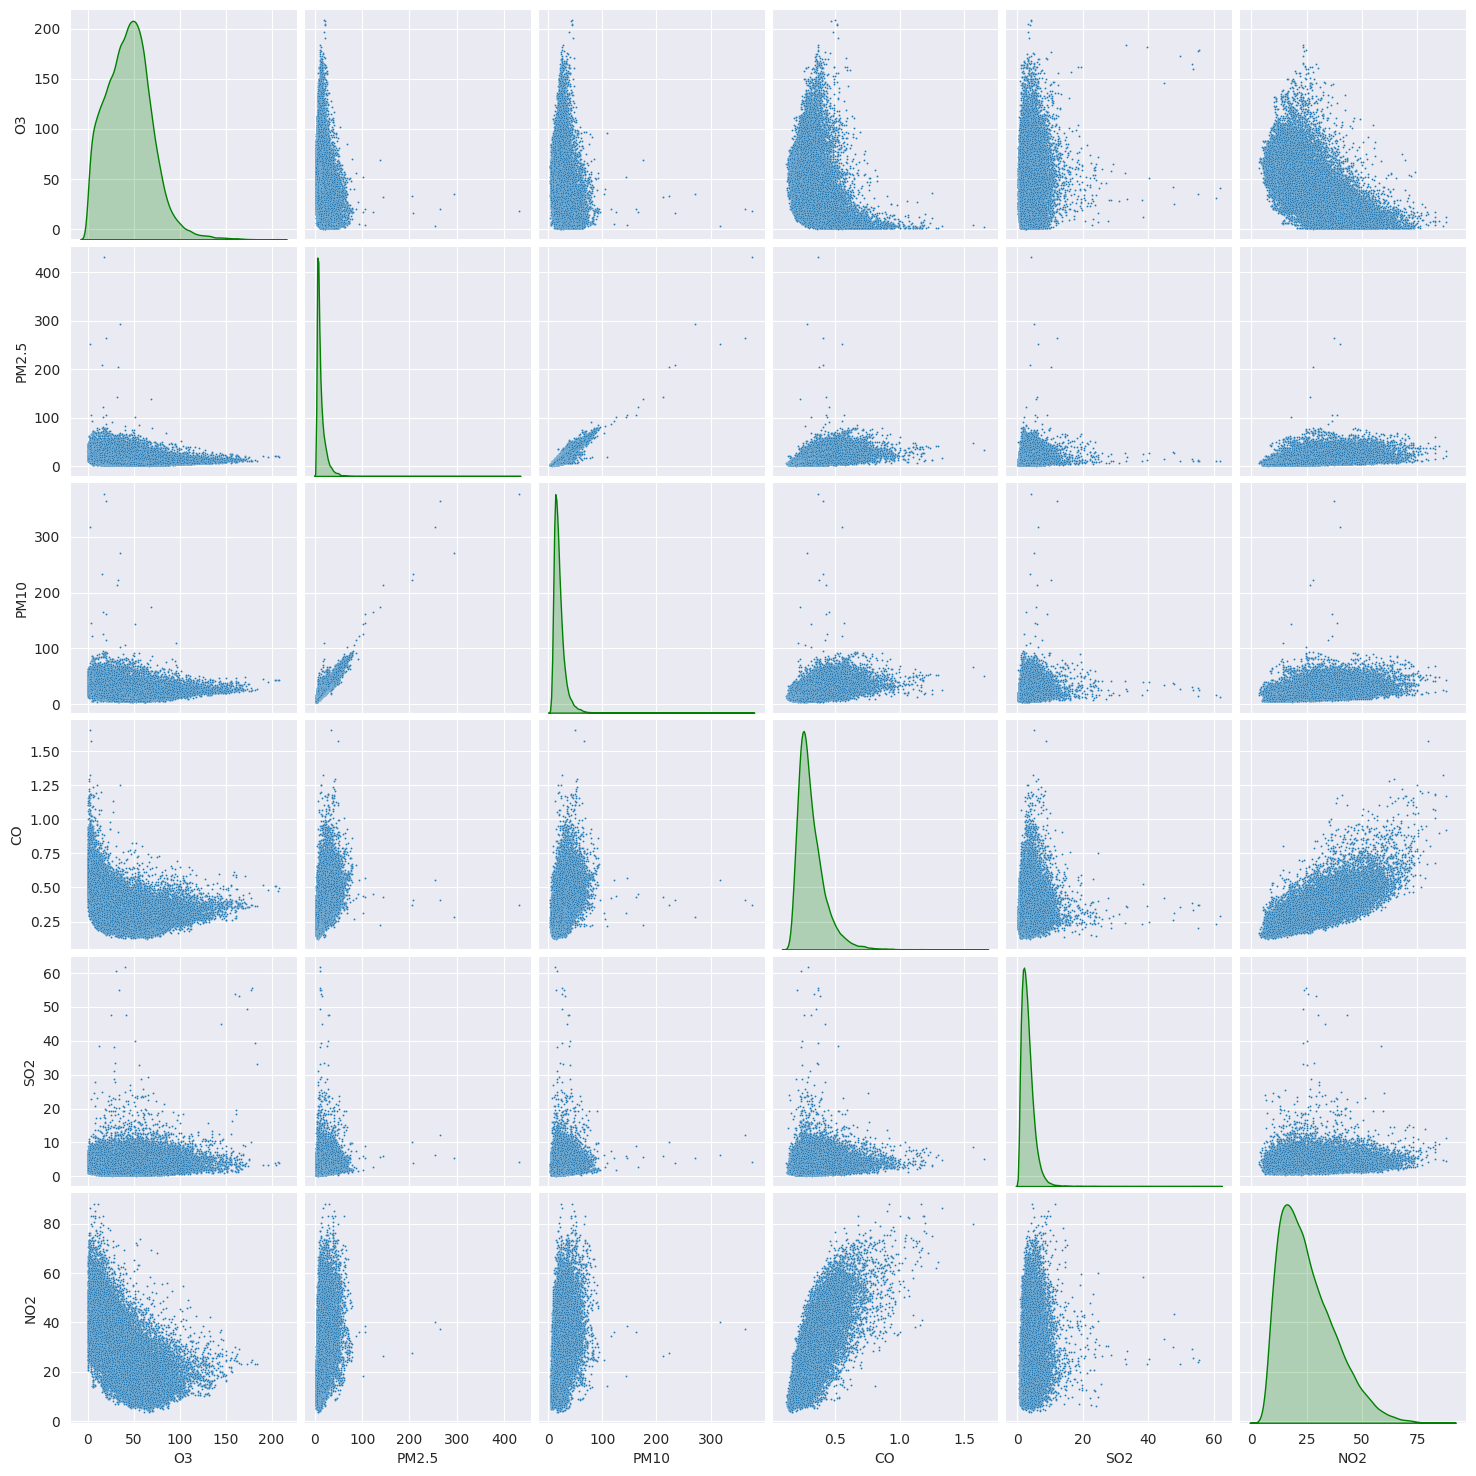

In [23]:
sns.pairplot(df_ts, diag_kind='kde', kind='scatter', plot_kws={"s": 2}, diag_kws={'color':'green'})
#sns.pairplot(df_ts, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}, "s": 1}, diag_kws={'color':'green'})

##### Коэффициенты корреляции

/tmp/ipykernel_46145/1705214608.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_ts.corr(), annot=True, fmt=".2f", cmap='cubehelix')


<AxesSubplot: >

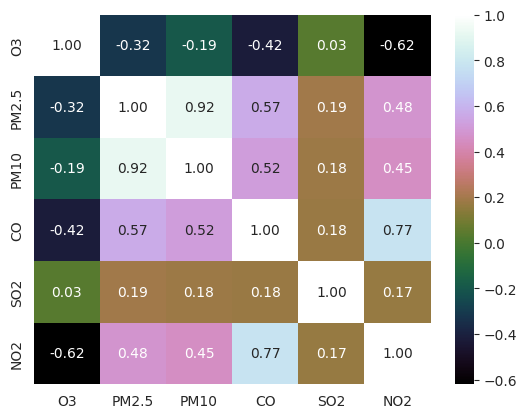

In [24]:
sns.heatmap(df_ts.corr(), annot=True, fmt=".2f", cmap='cubehelix')

<a id="ts_main_conc"></a>
*Выводы:*
1. Видна очень сильная корреляция между PM2.5 и PM10, что понятно, потому что у них один источник - сжигание угля и проч. К тому же возможно при измерении PM10 частично учитываются и PM2.5.
2. Есть умеренная корреляция между CO и PM2.5/PM10, , что понятно, потому что у них один источник - сжигание угля и проч.
3. Корреляция между SO2 и PM2.5/PM10 очень слабая, хотя у них предположительно также один источник.
4. Видна сильная концентрация между CO и NO2, что понятно, потому что у них один источник - сжигание дизельного топлива.
5. Имеется довольная сильная отрицательная корреляция между O3 и NO2. Связано это с механизмом формирования ground level ozone.

<a id="meta"></a>
***
#### Анализ в разрезе Метаданных о станциях
***

##### Загрузка метаданных, фильтр по требуемым загрязнителям

In [25]:
mdf = pd.read_csv(METADATA_CSV_PATH, sep='\t', usecols=METADATA_USE_COLUMNS)
pol_urls = {POL_URL + str(x):x for x in POL_CODES}
mdf = mdf[mdf['AirPollutantCode'].isin(pol_urls.keys())]
mdf.replace({'AirPollutantCode': pol_urls}, inplace=True)
print(f'Lines count: {mdf.shape[0]}')
mdf.head()

Lines count: 32480


,Countrycode,AirQualityStation,AirPollutantCode,Longitude,Latitude,Altitude,AirQualityStationType,AirQualityStationArea
0,AD,STA-AD0942A,1,1.539138,42.509694,1080.0,background,urban
1,AD,STA-AD0942A,5,1.539138,42.509694,1080.0,background,urban
2,AD,STA-AD0942A,7,1.539138,42.509694,1080.0,background,urban
3,AD,STA-AD0942A,8,1.539138,42.509694,1080.0,background,urban
5,AD,STA-AD0942A,10,1.539138,42.509694,1080.0,background,urban


##### Фильтрация метаданных по коду страны, если он задан

In [26]:
if country_code is not None and len(country_code) > 0:
    country_cond = mdf['Countrycode'] == country_code
    mdf = mdf[country_cond]
    print(f'Отфильтровано по стране: {country_code}. Всего станций: {mdf.shape[0]}')

Отфильтровано по стране: NL. Всего станций: 591


##### Объединение данных об изменерениях станций с метаданными

In [27]:
for i in range(len(POL_CODES)):
    df_list[i] = pd.merge(df_list[i], mdf, how='left', left_on=['Countrycode', 'AirQualityStation'], right_on=['Countrycode', 'AirQualityStation'])
display(df_list[0].columns)
df_list[0].head()

Index(['Countrycode', 'AirQualityStation', 'Concentration', 'DatetimeEnd', 'AirPollutantCode', 'Longitude', 'Latitude', 'Altitude', 'AirQualityStationType', 'AirQualityStationArea'], dtype='object')

,Countrycode,AirQualityStation,Concentration,DatetimeEnd,AirPollutantCode,Longitude,Latitude,Altitude,AirQualityStationType,AirQualityStationArea
0,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00,5,4.359376,52.039023,-2.0,background,suburban
1,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00,5,4.359376,52.039023,-2.0,background,suburban
2,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00,7,4.359376,52.039023,-2.0,background,suburban
3,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00,7,4.359376,52.039023,-2.0,background,suburban
4,NL,STA-NL00446,46.98,2014-06-25 04:00:00+01:00,7,4.359376,52.039023,-2.0,background,suburban


##### Подготовка dataframe для анализа в разрезе типа местности размещения станций: rural (сельскохозяйственная) и urban (урбанизированная), suburban (промежуточная)

In [28]:
df_area_list = list()
for i in range(len(POL_CODES)):
    df_area_list.append(df_list[i].groupby(['AirQualityStationArea', 'DatetimeEnd'], as_index=False)['Concentration'].mean())
    df_area_list[i].rename(columns={'Concentration': POL_NAMES[POL_CODES[i]]}, inplace=True)

df_area = reduce(lambda df1, df2: df1.merge(df2, how='outer', left_on=['AirQualityStationArea', 'DatetimeEnd'], right_on=['AirQualityStationArea', 'DatetimeEnd']), df_area_list)
print(df_area.shape[0])
df_area.head()

210384


,AirQualityStationArea,DatetimeEnd,O3,PM2.5,PM10,CO,SO2,NO2
0,rural,2013-01-01 01:00:00+01:00,56.180000,19.201379,39.460520,0.242500,2.768750,9.224974
1,rural,2013-01-01 02:00:00+01:00,55.508155,39.052414,39.082643,0.254694,2.397187,9.168598
2,rural,2013-01-01 03:00:00+01:00,56.428690,13.969655,19.626276,0.242548,1.924688,8.037222
3,rural,2013-01-01 04:00:00+01:00,56.463036,11.380690,15.688888,0.238500,1.342750,7.614153
4,rural,2013-01-01 05:00:00+01:00,55.031548,9.460690,13.360697,0.226887,2.147500,8.437446


##### Вывод статистики по концентрациям загрязнителей в разрезе типа местности

In [29]:
areas_types = list(df_area.groupby('AirQualityStationArea').groups.keys())
for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    print()
    pol_code = POL_NAMES[POL_CODES[i]]
    display(df_area.groupby('AirQualityStationArea')[pol_code].describe())
    #df_area.groupby('AirQualityStationArea').plot(x='DatetimeEnd', xlabel="Date", ylabel="Concentration", title=pol_code, y=pol_code, figsize=(21,7), ax=plt.gca())
    #plt.legend(areas_types)
    #plt.show()

--------------------------------------------POLLUTANT O3--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,70115.0,46.644660,24.558272,0.10,28.696898,46.366051,62.072738,210.896087
suburban,69583.0,45.706186,25.424459,0.13,26.878182,45.255758,61.375202,196.877879
urban,70127.0,42.242787,25.140732,0.10,23.184123,41.795750,58.286933,216.930260


--------------------------------------------POLLUTANT PM2.5--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,70128.0,11.283526,9.170911,0.724667,5.319609,8.161383,14.000717,120.798379
suburban,61204.0,11.585801,10.336573,0.002500,5.122769,8.520721,15.059074,656.079750
urban,70128.0,12.559440,10.045602,1.812731,6.358269,9.217242,15.333434,575.906691


--------------------------------------------POLLUTANT PM10--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,70128.0,18.650046,10.094030,3.194305,12.047898,16.114821,22.229566,308.889778
suburban,69519.0,19.830854,12.236915,0.590000,12.430000,17.372222,24.234444,801.372222
urban,70128.0,20.953732,11.172167,3.910111,13.928643,18.488460,24.935475,595.946583


--------------------------------------------POLLUTANT CO--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,70055.0,0.250215,0.100316,0.05290,0.182930,0.225952,0.293085,1.547643
suburban,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urban,70127.0,0.331610,0.117829,0.12061,0.250969,0.303432,0.383619,1.681864


--------------------------------------------POLLUTANT SO2--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,70029.0,1.910159,1.767908,0.01,0.843488,1.509804,2.493953,66.330625
suburban,44593.0,1.031762,1.371207,0.01,0.250000,0.570000,1.290000,25.170000
urban,70128.0,4.086410,3.061957,0.14,2.145935,3.284410,5.100000,88.418000


--------------------------------------------POLLUTANT NO2--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationArea,,,,,,,,
rural,43824.0,18.148915,10.188153,2.249609,10.242457,15.701156,23.993635,66.850707
suburban,43823.0,23.133140,13.024832,2.089762,13.006190,20.339048,30.749286,115.473333
urban,43824.0,30.302314,14.256752,4.357829,19.289065,27.707396,38.969675,108.092589


<a id="meta_area_conc"></a>
*Выводы:*
1. В среднем концентрации О3, PM2.5, PM10 не зависят от типа местности.
2. Концентрации CO в урабанизированной местности немного выше, чем в сельской. По suburban местности данных нет.
3. Концентрации SO2 максимальна в урбанизированной местности (в 2 раза выше, чем в сельской), что вероятно связано с наличием там заводов и тепловых станций. Почему в suburban местности средняя концентрация почти в 2 раза меньше, чем в сельской, неясно.
4. Концентрации NO2 максимальна в урбанизированной местности (в 1.5 раза выше, чем в сельской), и немного выше в suburban. Что вероятно связано с большим количеством транспорта в них.

##### Подготовка dataframe для анализа в разрезе типа станций: background (нет доминирующих источников), industrial (источники - заводы, теплостанции и проч) и traffic (источники - транспорт)

In [30]:
df_station_type_list = list()
for i in range(len(POL_CODES)):
    df_station_type_list.append(df_list[i].groupby(['AirQualityStationType', 'DatetimeEnd'], as_index=False)['Concentration'].mean())
    df_station_type_list[i].rename(columns={'Concentration': POL_NAMES[POL_CODES[i]]}, inplace=True)

df_station_type = reduce(lambda df1, df2: df1.merge(df2, how='outer', left_on=['AirQualityStationType', 'DatetimeEnd'], right_on=['AirQualityStationType', 'DatetimeEnd']), df_station_type_list)
display(df_station_type.shape[0])
df_station_type.head()

210384

,AirQualityStationType,DatetimeEnd,O3,PM2.5,PM10,CO,SO2,NO2
0,background,2013-01-01 01:00:00+01:00,51.782313,120.276721,109.865451,0.265317,3.231304,14.370573
1,background,2013-01-01 02:00:00+01:00,53.733955,54.672131,45.103979,0.258817,2.138913,11.042479
2,background,2013-01-01 03:00:00+01:00,55.236759,21.458361,21.398348,0.249827,1.721522,9.323558
3,background,2013-01-01 04:00:00+01:00,55.336082,14.185574,14.488433,0.241433,1.358704,9.132277
4,background,2013-01-01 05:00:00+01:00,54.684216,9.628852,12.828628,0.232240,1.180370,9.284580


##### Вывод статистики по концентрациям загрязнителей в разрезе типа станций

In [31]:
station_types = list(df_station_type.groupby('AirQualityStationType').groups.keys())
for i in range(len(POL_CODES)):
    print(f'--------------------------------------------POLLUTANT {POL_NAMES[POL_CODES[i]]}--------------------------------------------')
    print()
    pol_code = POL_NAMES[POL_CODES[i]]
    display(df_station_type.groupby('AirQualityStationType')[pol_code].describe())
    #df_station_type.groupby('AirQualityStationType').plot(x='DatetimeEnd', xlabel="Date", ylabel="Concentration", title=pol_code, y=pol_code, figsize=(21,7), ax=plt.gca())
    #plt.legend(station_types)
    #plt.show()

--------------------------------------------POLLUTANT O3--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,70127.0,46.194074,25.061504,0.10,27.767917,45.786967,61.723458,208.684588
industrial,69463.0,43.282877,24.983495,0.10,25.151613,43.416129,59.688710,239.696774
traffic,70069.0,38.577734,24.535247,0.02,19.046290,37.644394,54.634355,202.509677


--------------------------------------------POLLUTANT PM2.5--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,70128.0,11.615467,9.473398,1.435610,5.580452,8.464820,14.362417,400.835232
industrial,70125.0,12.892347,10.018274,0.400000,6.546774,9.550385,15.626984,336.405172
traffic,70128.0,12.734364,10.165348,0.490971,6.352924,9.417931,15.719171,475.289426


--------------------------------------------POLLUTANT PM10--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,70128.0,18.882778,10.120845,3.244294,12.315156,16.395003,22.505151,290.496473
industrial,70128.0,21.315118,11.293057,2.353846,13.857231,18.814003,25.637106,374.726667
traffic,70128.0,21.522348,11.700973,2.115273,14.336953,18.990049,25.574840,621.236692


--------------------------------------------POLLUTANT CO--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,70126.0,0.262719,0.097409,0.093637,0.197941,0.241409,0.301833,2.252822
industrial,69289.0,0.321259,0.208935,0.001000,0.215150,0.265000,0.357900,8.583000
traffic,70122.0,0.368987,0.144695,0.110585,0.274048,0.337048,0.428731,2.439322


--------------------------------------------POLLUTANT SO2--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,70018.0,1.301930,1.217445,0.010000,0.495938,1.00500,1.733321,39.234918
industrial,70128.0,4.470284,3.266821,0.147619,2.375919,3.67388,5.603279,75.413115
traffic,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------POLLUTANT NO2--------------------------------------------



,count,mean,std,min,25%,50%,75%,max
AirQualityStationType,,,,,,,,
background,43824.0,19.895565,11.073510,2.439000,11.242035,17.338284,26.394064,73.388007
industrial,43824.0,27.548484,14.203528,3.271429,16.738095,24.667544,35.586115,114.867478
traffic,43824.0,35.678346,16.157231,4.052993,23.354003,33.304997,45.849808,130.546434


<a id="meta_st_type_conc"></a>
*Выводы:*
1. Концентрации О3 для станций background несколько выше, но существенно для разных типов станций не отличаются.
2. Концентрации PM2.5, PM10, CO существенно для разных типов станций не отличаются, в industrial / traffic немного выше.
3. Данных о SO2 для станций traffic нет. Для industrial в 3 раза выше, чем для и background.
4. Концентрации NO2 в среднем почти в 2 раза выше для станций traffic, чем для background, и почти в 1,5 раза выше для станций industrial, чем для background.